In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Define the hyperparameter search space for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

In [5]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        print(f"\n--- Processing Fold {fold} ---")
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = XGBClassifier(**best_params, random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC Calculation
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        # Classification report
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average Metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importance
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    print("\nFeature Importances:")
    print(feature_importances)

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===

--- Processing Fold 1 ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83      1785
           1       0.61      0.38      0.47       604
           2       0.51      0.35      0.42       258
           3       0.31      0.15      0.20        59
           4       0.25      0.11      0.15         9

    accuracy                           0.72      2715
   macro avg       0.49      0.38      0.42      2715
weighted avg       0.70      0.72      0.70      2715



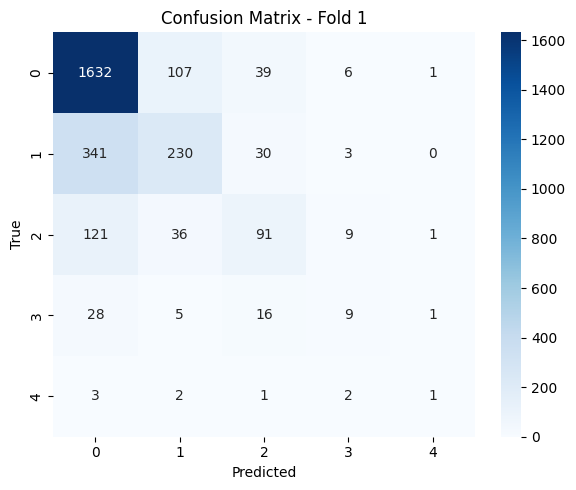

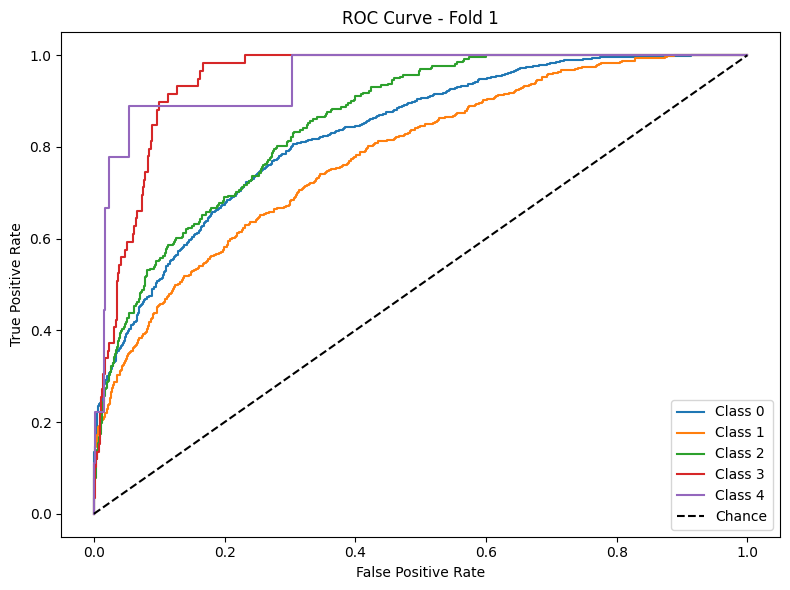


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1786
           1       0.59      0.36      0.44       603
           2       0.56      0.37      0.45       258
           3       0.37      0.22      0.28        59
           4       0.00      0.00      0.00         8

    accuracy                           0.72      2714
   macro avg       0.46      0.37      0.40      2714
weighted avg       0.69      0.72      0.70      2714



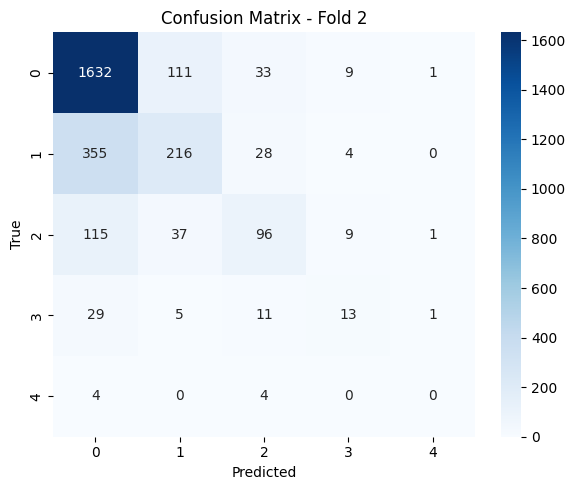

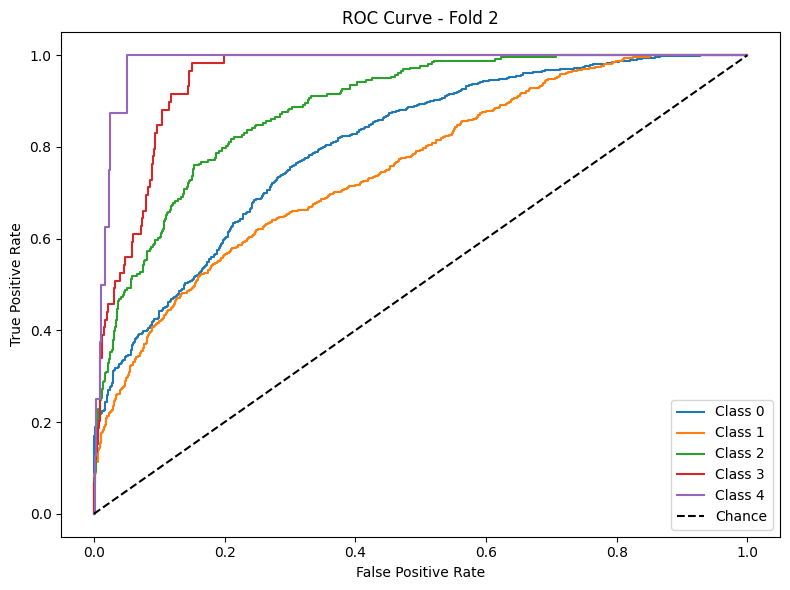


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1786
           1       0.60      0.40      0.48       603
           2       0.49      0.33      0.39       258
           3       0.45      0.22      0.30        59
           4       0.40      0.25      0.31         8

    accuracy                           0.72      2714
   macro avg       0.54      0.42      0.46      2714
weighted avg       0.70      0.72      0.70      2714



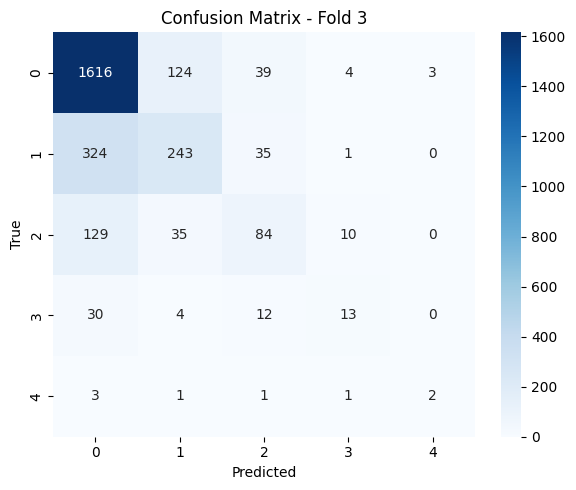

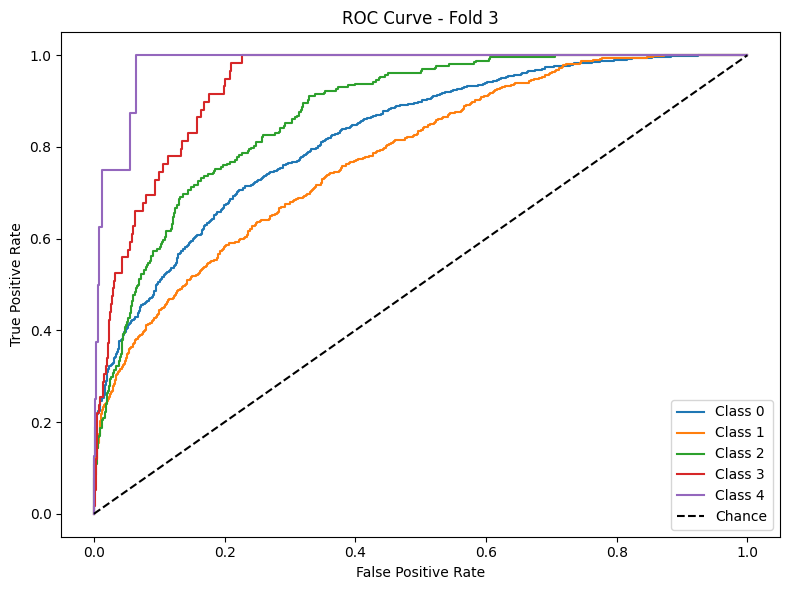


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84      1785
           1       0.61      0.41      0.49       603
           2       0.59      0.41      0.48       258
           3       0.32      0.14      0.19        59
           4       0.00      0.00      0.00         9

    accuracy                           0.73      2714
   macro avg       0.46      0.37      0.40      2714
weighted avg       0.71      0.73      0.71      2714



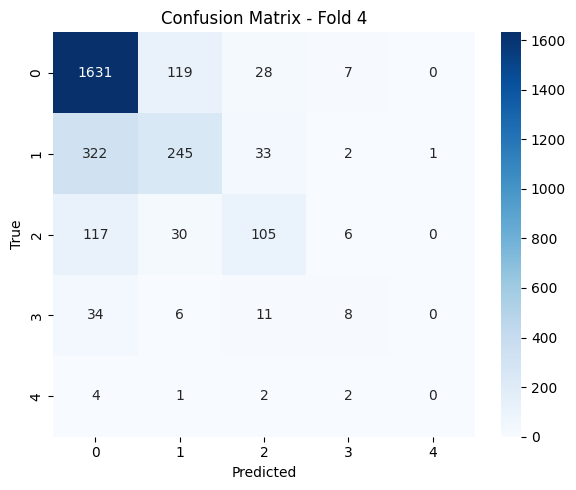

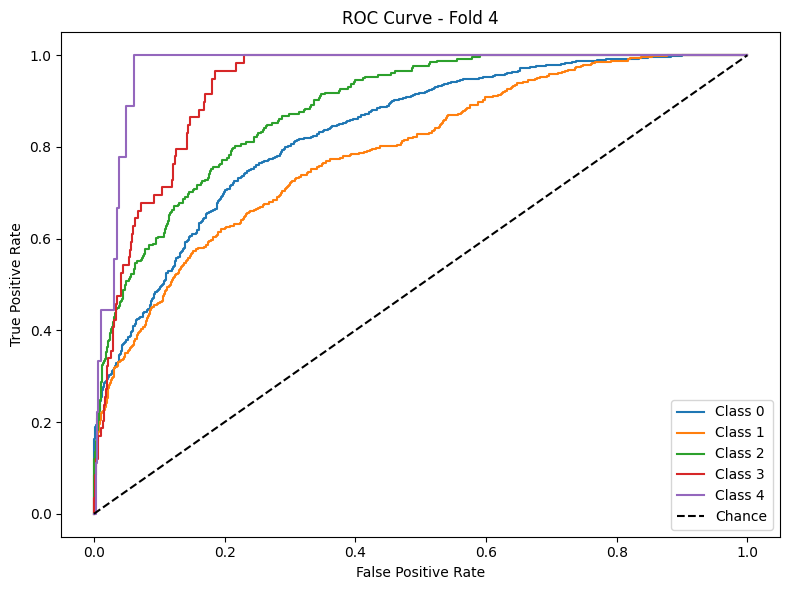


--- Processing Fold 5 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84      1785
           1       0.61      0.36      0.45       603
           2       0.57      0.36      0.44       258
           3       0.42      0.17      0.24        59
           4       0.00      0.00      0.00         9

    accuracy                           0.73      2714
   macro avg       0.47      0.36      0.39      2714
weighted avg       0.70      0.73      0.70      2714



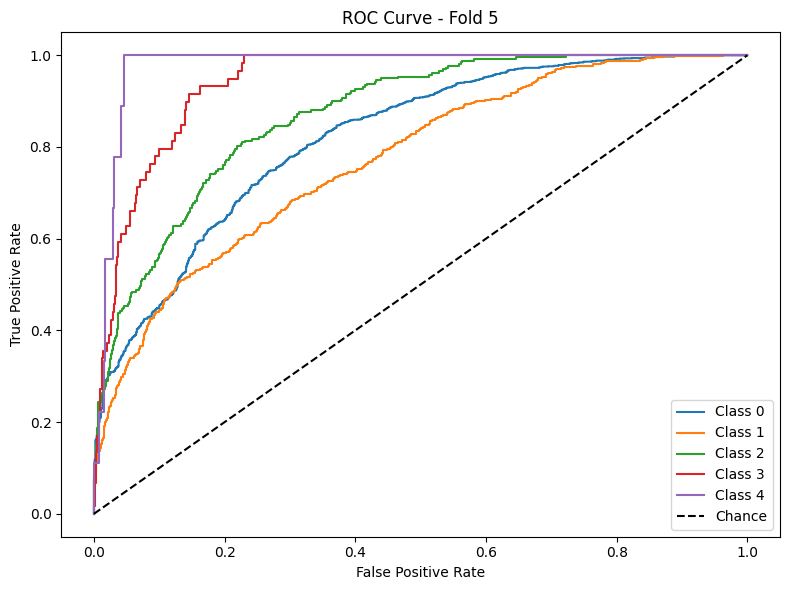


Average Accuracy: 0.7255
Average F1 Macro: 0.4143
Average AUC: 0.8769

Feature Importances:
video                                  0.085748
assignment                             0.080624
duration_days                          0.052489
video_count                            0.049167
exercise_correct_sum_1                 0.049052
end_year                               0.040728
exercise_count                         0.036978
exam                                   0.031201
exercise_perc_real_score_mean_1        0.029416
exercise_id_count_1                    0.028637
exercise_langugage_binary_mean_1       0.024465
num_prerequisites                      0.023592
exercise_correct_mean_1                0.022863
chapter_count                          0.021641
exercise_context_sum_1                 0.020777
school                                 0.019465
encoded_field_sum                      0.017728
user_time_since_last_course            0.014962
combined_emb_3                         0.01

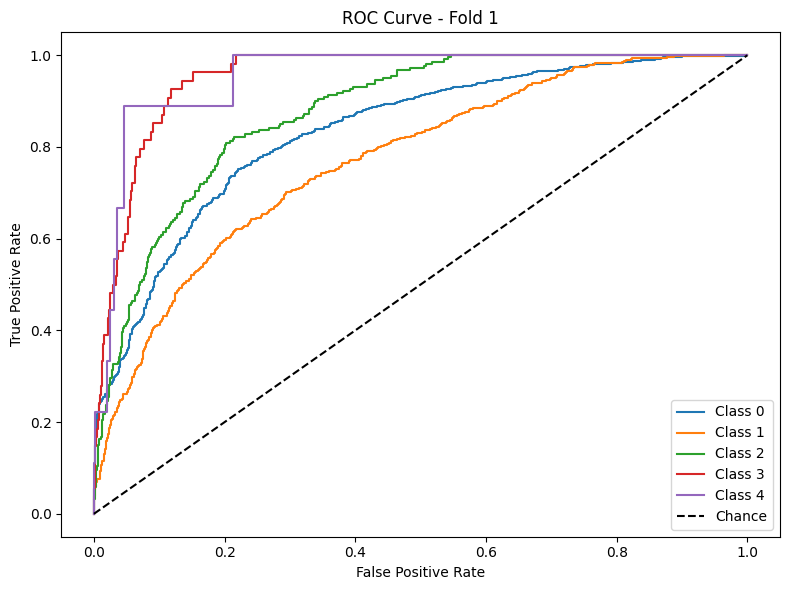


--- Processing Fold 2 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.84      1489
           1       0.57      0.27      0.37       489
           2       0.53      0.32      0.40       219
           3       0.24      0.16      0.19        55
           4       0.00      0.00      0.00         8

    accuracy                           0.71      2260
   macro avg       0.42      0.34      0.36      2260
weighted avg       0.68      0.71      0.67      2260



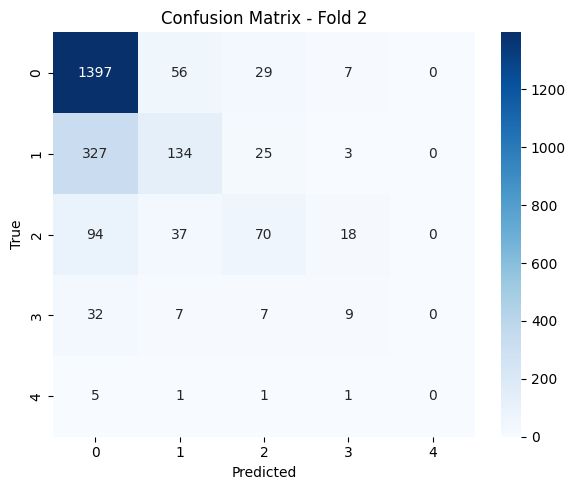

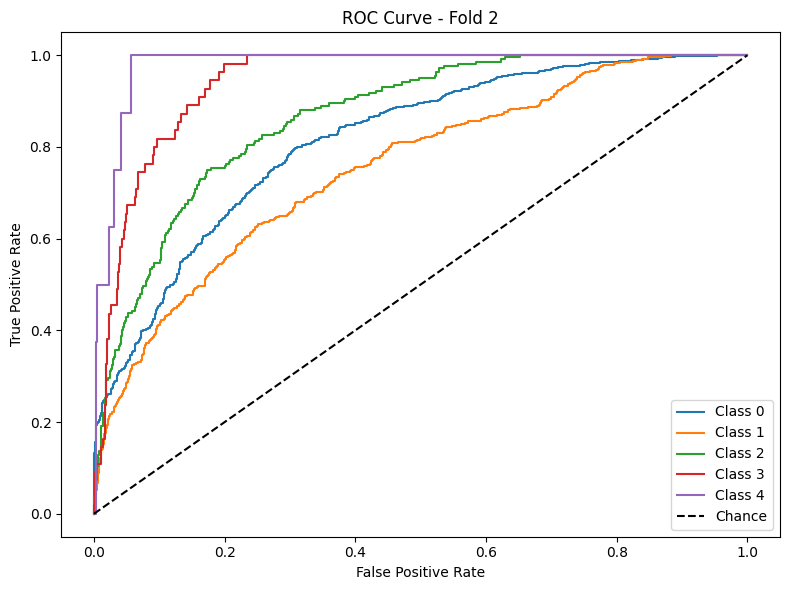


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83      1489
           1       0.57      0.25      0.34       489
           2       0.49      0.33      0.40       219
           3       0.21      0.15      0.17        54
           4       1.00      0.12      0.22         8

    accuracy                           0.71      2259
   macro avg       0.60      0.36      0.39      2259
weighted avg       0.67      0.71      0.67      2259



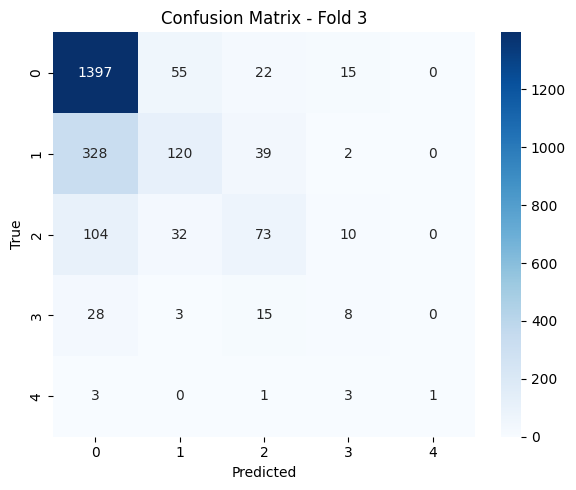


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83      1489
           1       0.59      0.26      0.36       489
           2       0.48      0.31      0.37       219
           3       0.29      0.11      0.16        54
           4       0.60      0.38      0.46         8

    accuracy                           0.71      2259
   macro avg       0.54      0.40      0.44      2259
weighted avg       0.67      0.71      0.67      2259



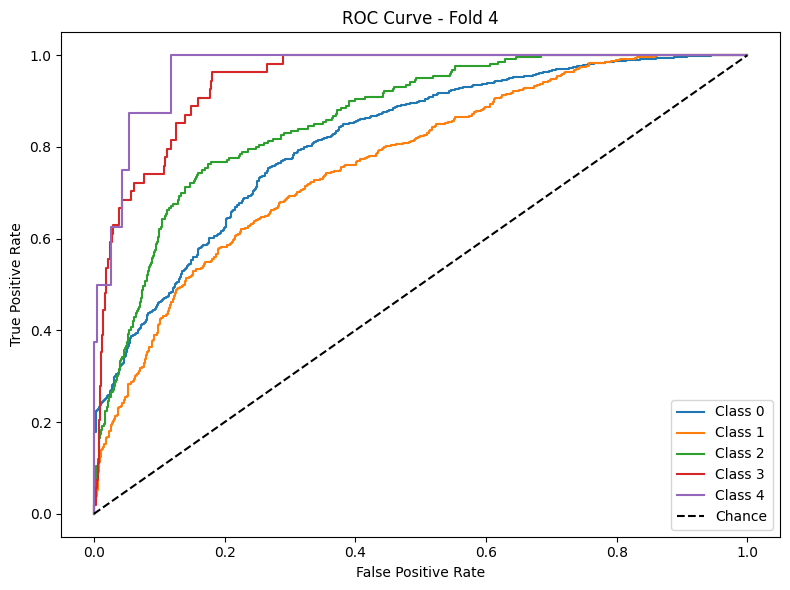


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.85      1490
           1       0.60      0.34      0.44       488
           2       0.46      0.34      0.39       219
           3       0.07      0.02      0.03        54
           4       0.33      0.12      0.18         8

    accuracy                           0.72      2259
   macro avg       0.45      0.35      0.38      2259
weighted avg       0.69      0.72      0.69      2259




Average Accuracy: 0.7138
Average F1 Macro: 0.3951
Average AUC: 0.8749

Feature Importances:
video                                  0.047906
assignment                             0.041602
duration_days                          0.038383
exercise_context_sum_1                 0.033222
exercise_correct_mean_2                0.029295
exercise_count                         0.023866
exercise_perc_real_score_mean_2        0.023025
combined_emb_4                         0.021501
exercise_correct_sum_2                 0.020564
combined_emb_9                         0.020450
combined_emb_11                        0.019459
video_count                            0.019409
chapter_count                          0.018462
exercise_context_sum_2                 0.018418
user_time_since_last_course            0.018290
exercise_correct_sum_1                 0.018265
exercise_num_problem_sum_1             0.018255
exercise_perc_real_completed_mean_1    0.018204
encoded_field_sum                      0.01

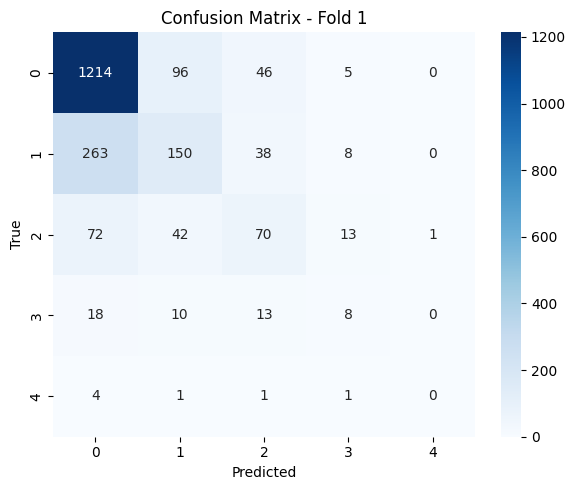

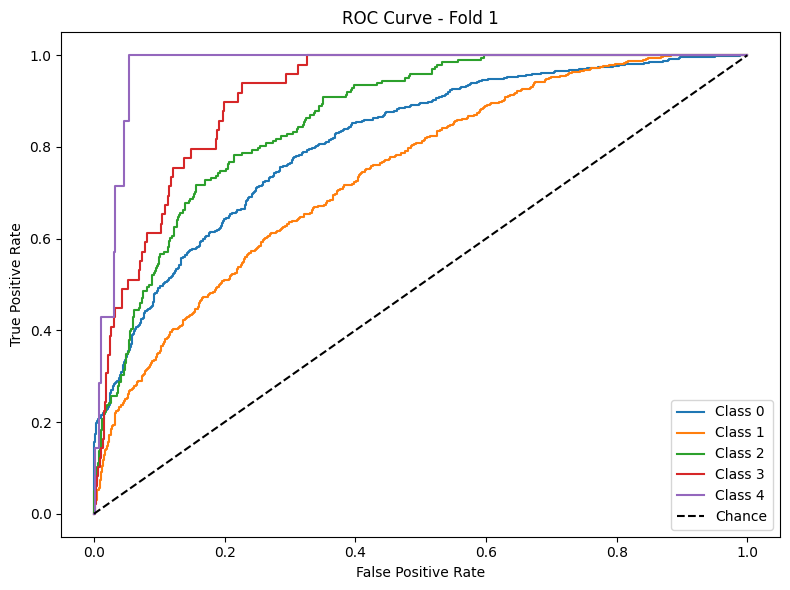


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82      1360
           1       0.46      0.34      0.39       459
           2       0.46      0.34      0.39       198
           3       0.48      0.26      0.34        50
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.43      0.36      0.39      2074
weighted avg       0.66      0.69      0.67      2074




--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83      1360
           1       0.49      0.36      0.42       459
           2       0.43      0.36      0.39       198
           3       0.39      0.28      0.33        50
           4       0.00      0.00      0.00         7

    accuracy                           0.70      2074
   macro avg       0.42      0.38      0.39      2074
weighted avg       0.67      0.70      0.68      2074



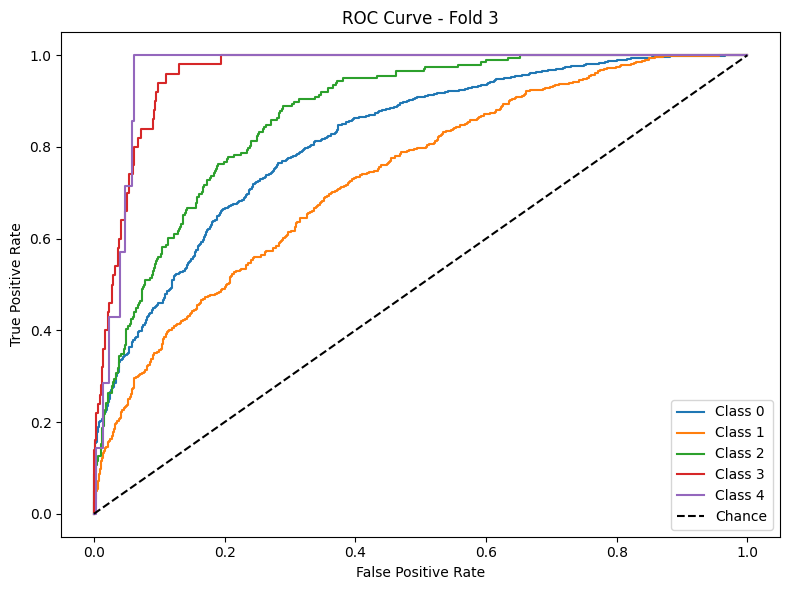


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      1360
           1       0.47      0.37      0.41       459
           2       0.45      0.31      0.37       198
           3       0.31      0.18      0.23        50
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.40      0.35      0.37      2074
weighted avg       0.66      0.69      0.67      2074



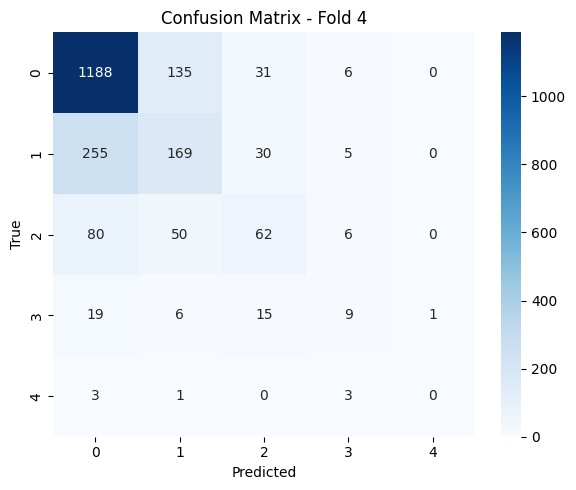

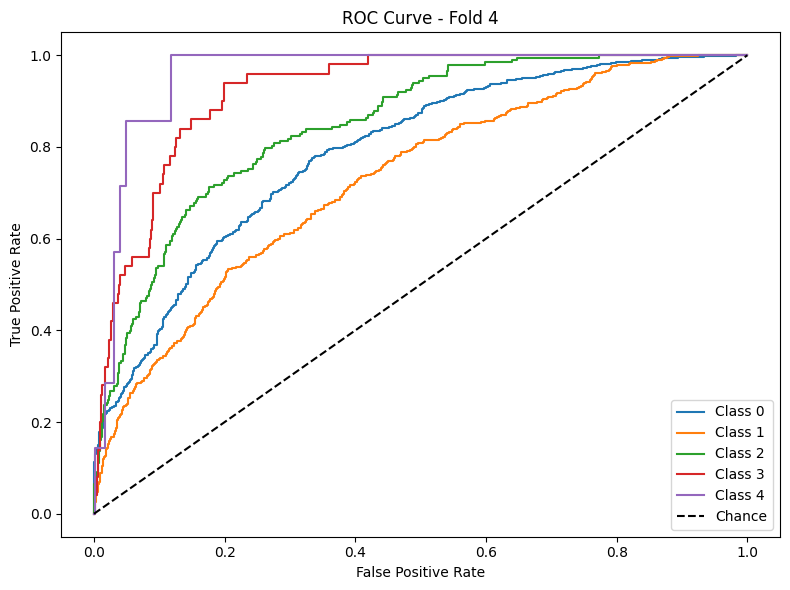


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      1360
           1       0.47      0.37      0.41       460
           2       0.44      0.33      0.38       197
           3       0.42      0.29      0.34        49
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2073
   macro avg       0.42      0.37      0.39      2073
weighted avg       0.67      0.69      0.68      2073




Average Accuracy: 0.6938
Average F1 Macro: 0.3794
Average AUC: 0.8579

Feature Importances:
video                                  0.074544
num_prerequisites                      0.047904
exercise_context_sum_1                 0.040100
assignment                             0.038609
exam                                   0.034430
exercise_context_sum_2                 0.033941
duration_days                          0.028892
encoded_field_sum                      0.028297
exercise_context_sum_3                 0.024429
exercise_correct_sum_1                 0.023131
exercise_langugage_binary_mean_3       0.022299
exercise_perc_real_completed_mean_3    0.019229
exercise_perc_real_score_mean_2        0.018503
exercise_count                         0.017358
exercise_correct_mean_3                0.016934
exercise_perc_real_completed_mean_1    0.016216
video_count                            0.015565
exercise_correct_sum_2                 0.014909
end_year                               0.01


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84      1000
           1       0.56      0.36      0.44       355
           2       0.55      0.37      0.44       139
           3       0.42      0.33      0.37        40
           4       0.25      0.20      0.22         5

    accuracy                           0.72      1539
   macro avg       0.51      0.43      0.46      1539
weighted avg       0.69      0.72      0.70      1539



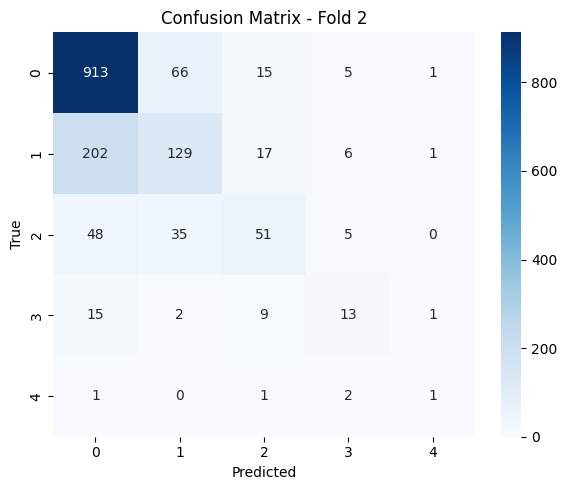


--- Processing Fold 3 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86       999
           1       0.63      0.43      0.51       355
           2       0.58      0.36      0.44       139
           3       0.41      0.30      0.35        40
           4       0.00      0.00      0.00         6

    accuracy                           0.75      1539
   macro avg       0.48      0.41      0.43      1539
weighted avg       0.72      0.75      0.72      1539




--- Processing Fold 4 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.94      0.85       999
           1       0.65      0.35      0.45       356
           2       0.49      0.37      0.42       138
           3       0.33      0.26      0.29        39
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1538
   macro avg       0.45      0.38      0.40      1538
weighted avg       0.71      0.73      0.70      1538



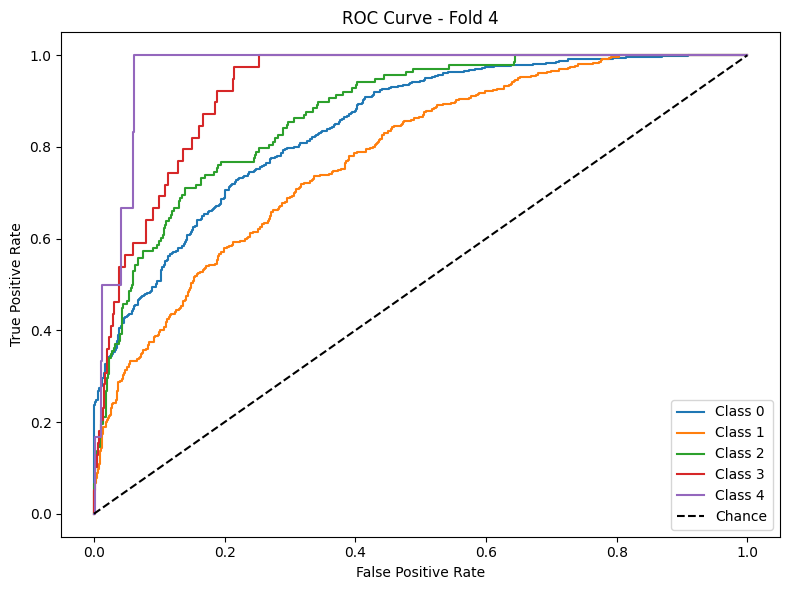


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       999
           1       0.57      0.36      0.44       356
           2       0.43      0.33      0.37       138
           3       0.44      0.49      0.46        39
           4       0.00      0.00      0.00         6

    accuracy                           0.72      1538
   macro avg       0.45      0.42      0.42      1538
weighted avg       0.69      0.72      0.70      1538



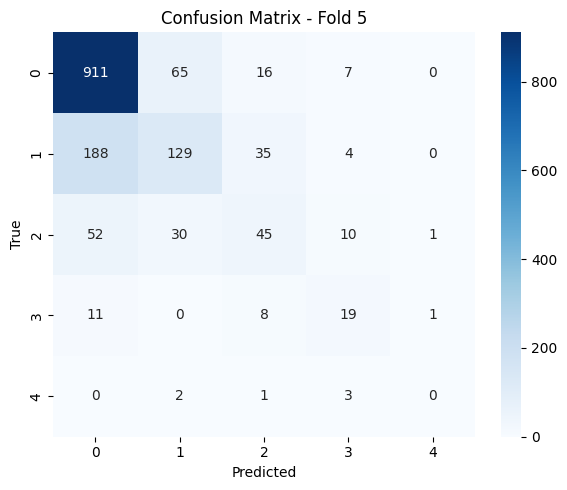

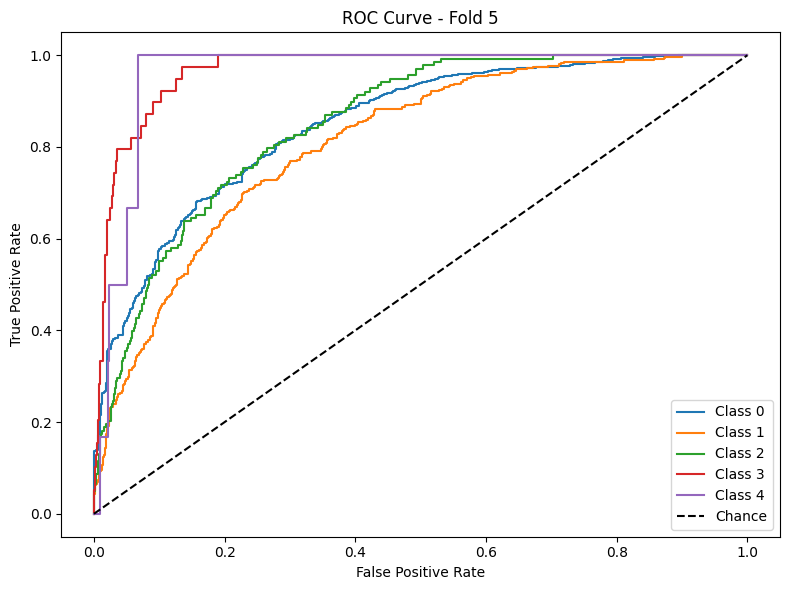


Average Accuracy: 0.7307
Average F1 Macro: 0.4432
Average AUC: 0.8834

Feature Importances:
assignment                             0.027313
exercise_count                         0.025020
exercise_correct_mean_2                0.024459
exercise_context_sum_1                 0.022962
duration_days                          0.022415
video                                  0.020565
exercise_context_sum_3                 0.019284
exercise_num_problem_sum_1             0.019163
user_time_since_last_course            0.018941
school                                 0.018861
exercise_context_sum_4                 0.018664
exercise_correct_sum_1                 0.016664
exercise_attempts_sum_mean_2           0.016360
exercise_correct_sum_4                 0.015829
video_count                            0.015385
combined_emb_1                         0.015195
num_prerequisites                      0.014851
exercise_context_sum_2                 0.014598
exercise_perc_real_score_mean_2        0.01

In [6]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [7]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       568
           1       0.59      0.25      0.36        63
           2       0.35      0.21      0.26        43
           3       0.50      0.07      0.12        15
           4       0.67      0.22      0.33         9

    accuracy                           0.84       698
   macro avg       0.59      0.35      0.40       698
weighted avg       0.80      0.84      0.80       698



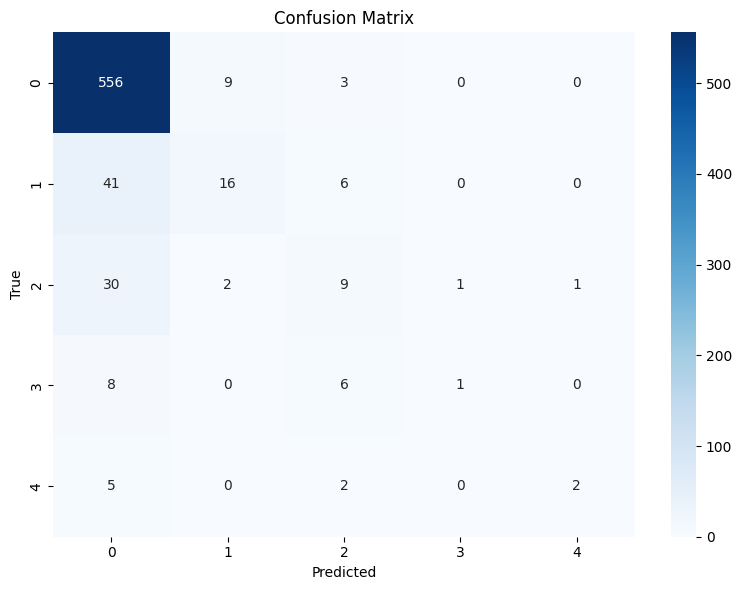


Test AUC (macro-average, OVR): 0.8901


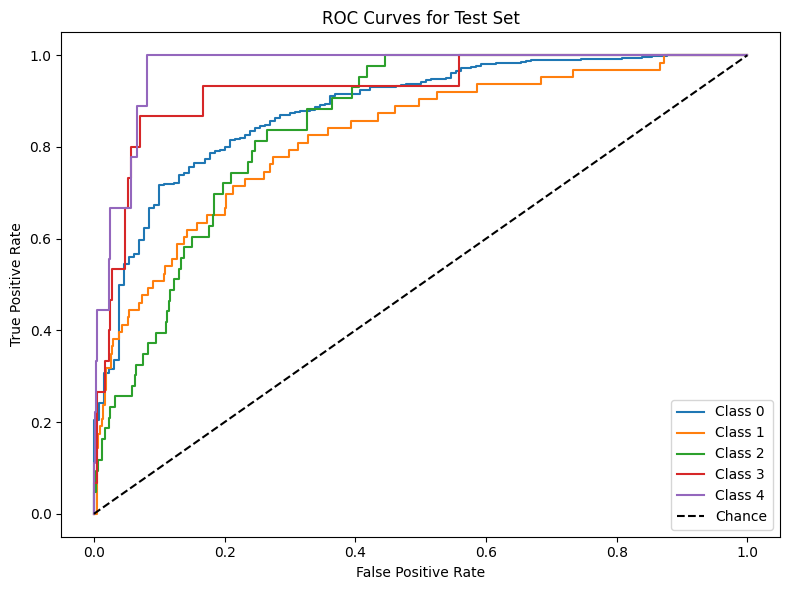


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       544
           1       0.36      0.17      0.23        59
           2       0.14      0.07      0.10        42
           3       0.33      0.07      0.12        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.34      0.26      0.27       668
weighted avg       0.75      0.82      0.78       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


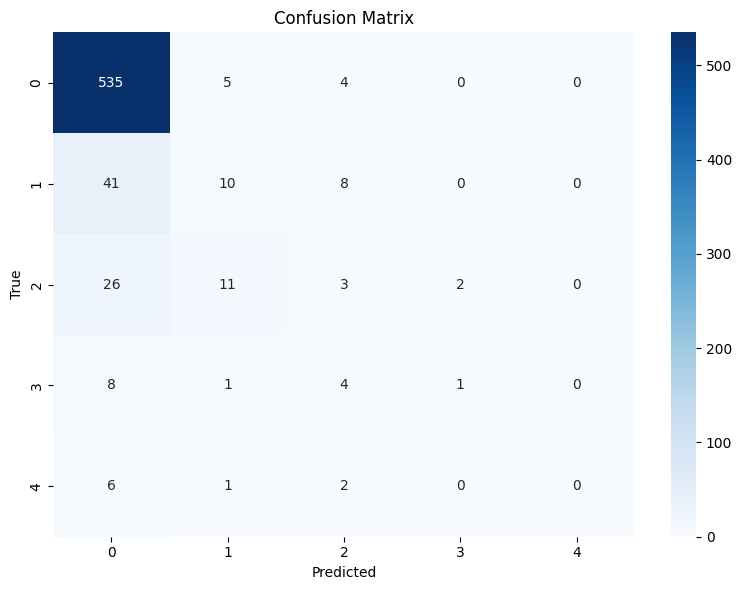


Test AUC (macro-average, OVR): 0.8781


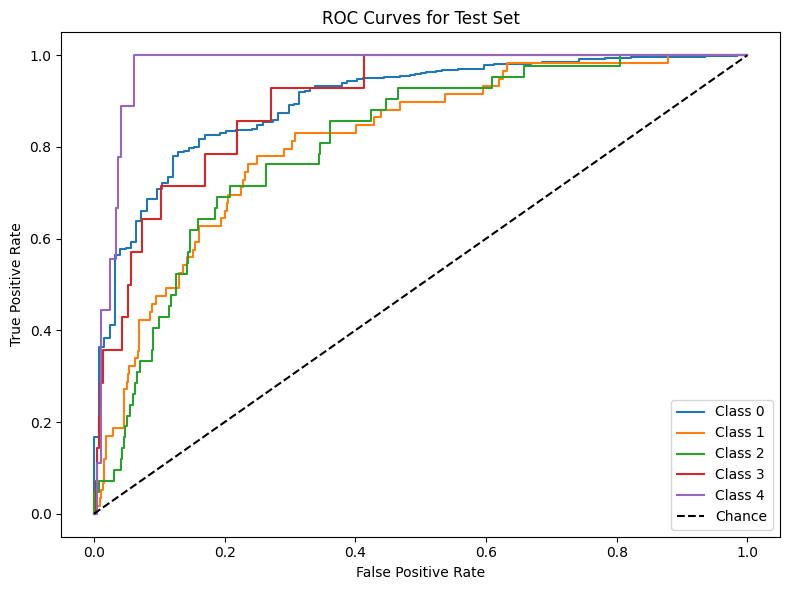


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       455
           1       0.36      0.08      0.13        52
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.24      0.21      0.21       554
weighted avg       0.72      0.82      0.76       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


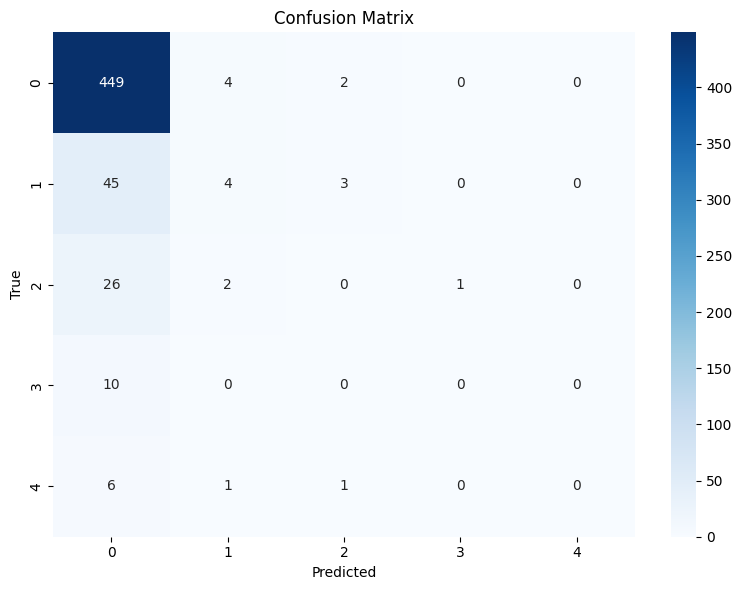


Test AUC (macro-average, OVR): 0.8222


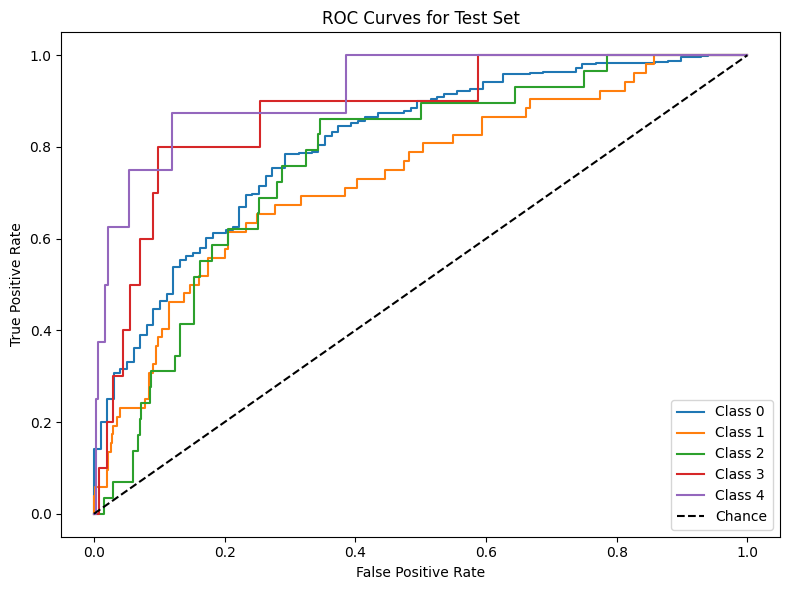


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       395
           1       0.11      0.05      0.07        40
           2       0.30      0.12      0.18        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.25      0.23      0.23       477
weighted avg       0.73      0.81      0.76       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


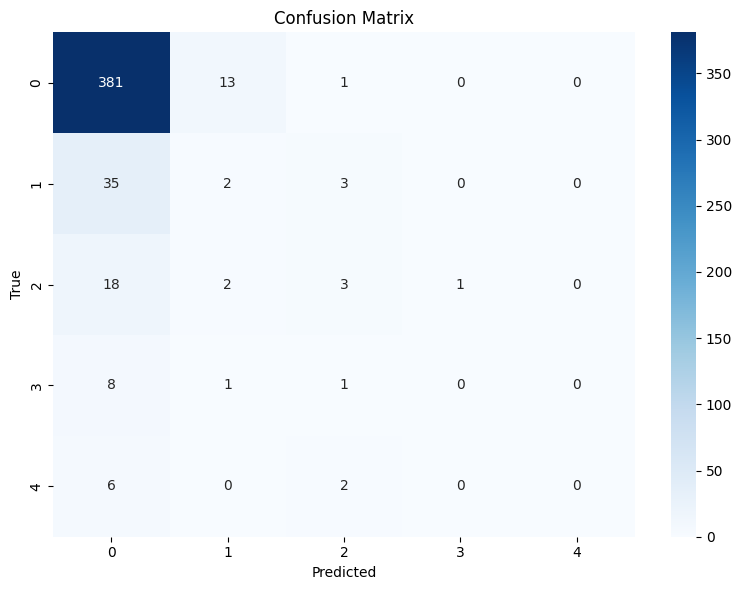


Test AUC (macro-average, OVR): 0.7413


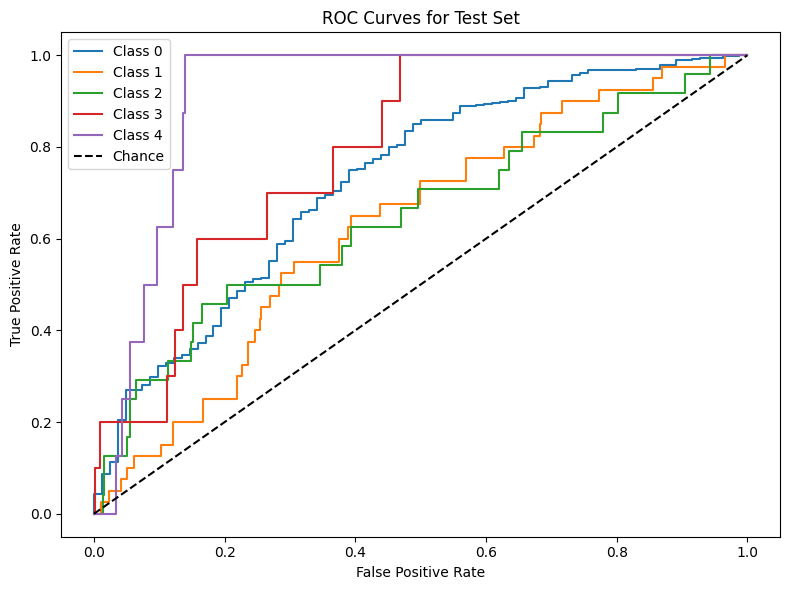

In [8]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample



========== Training Phase 1 ================


--- Processing Fold 1 ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1785
           1       0.52      0.48      0.50       604
           2       0.40      0.45      0.43       258
           3       0.22      0.34      0.27        59
           4       0.09      0.11      0.10         9

    accuracy                           0.69      2715
   macro avg       0.41      0.44      0.42      2715
weighted avg       0.69      0.69      0.69      2715



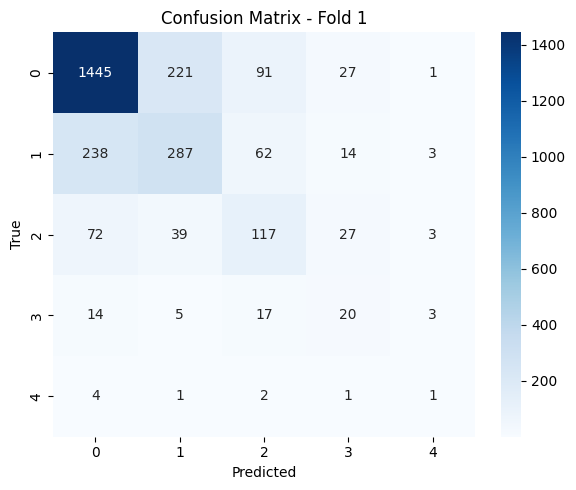

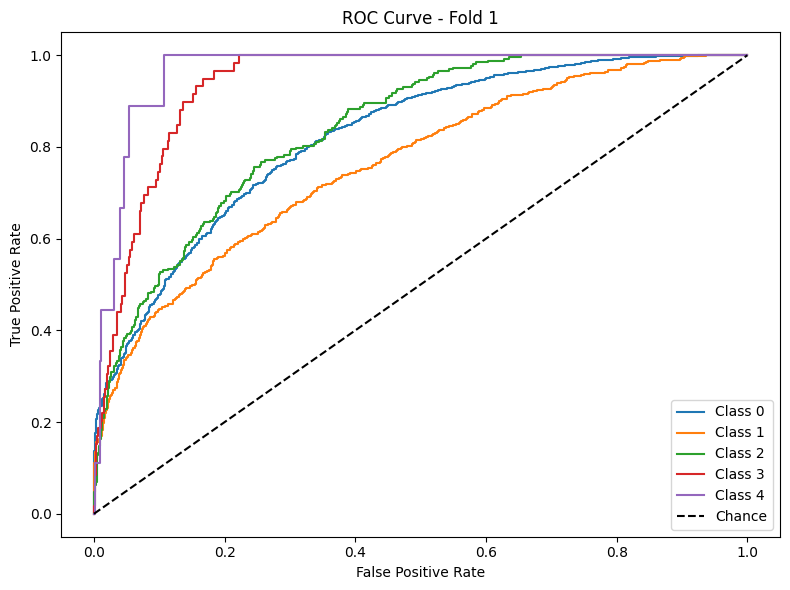


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1786
           1       0.53      0.45      0.48       603
           2       0.41      0.53      0.46       258
           3       0.33      0.47      0.39        59
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2714
   macro avg       0.42      0.45      0.43      2714
weighted avg       0.70      0.69      0.70      2714



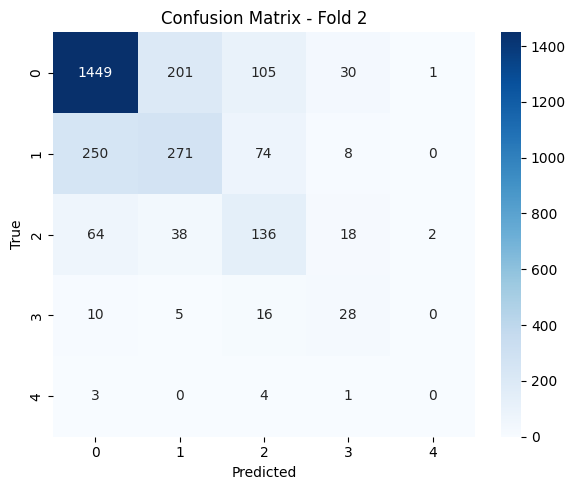

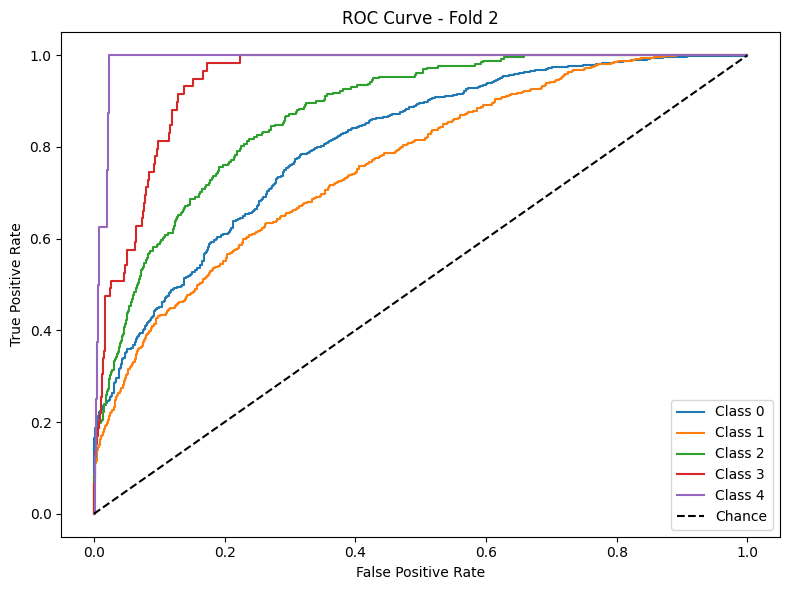


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1786
           1       0.52      0.48      0.50       603
           2       0.40      0.50      0.44       258
           3       0.23      0.34      0.28        59
           4       0.17      0.25      0.20         8

    accuracy                           0.69      2714
   macro avg       0.43      0.47      0.45      2714
weighted avg       0.70      0.69      0.69      2714



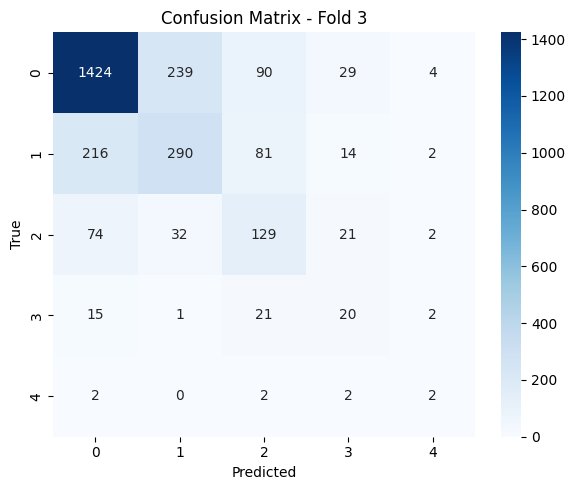

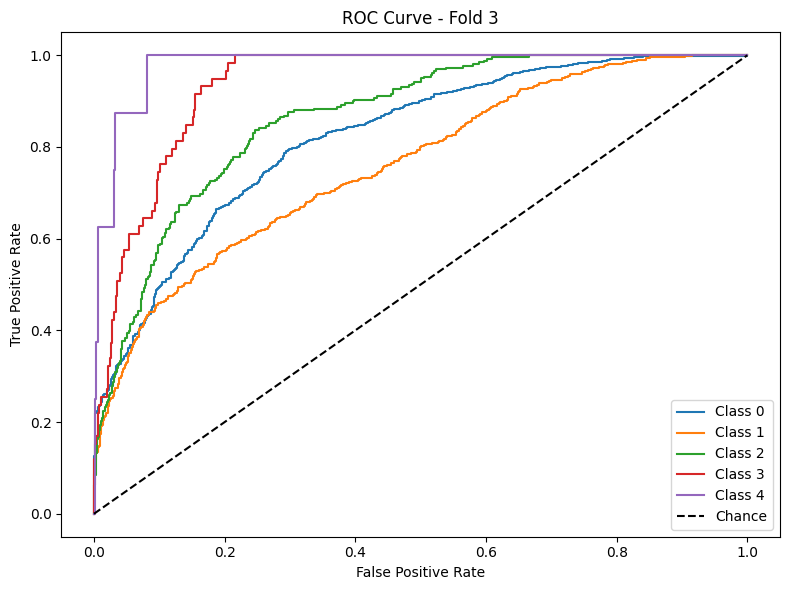


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82      1785
           1       0.53      0.50      0.51       603
           2       0.43      0.51      0.47       258
           3       0.24      0.29      0.26        59
           4       0.14      0.11      0.12         9

    accuracy                           0.70      2714
   macro avg       0.43      0.44      0.44      2714
weighted avg       0.71      0.70      0.70      2714




--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82      1785
           1       0.53      0.47      0.50       603
           2       0.44      0.48      0.46       258
           3       0.24      0.39      0.30        59
           4       1.00      0.11      0.20         9

    accuracy                           0.70      2714
   macro avg       0.60      0.45      0.45      2714
weighted avg       0.70      0.70      0.70      2714




Average Accuracy: 0.6935
Average F1 Macro: 0.4374
Average AUC: 0.8731

Feature Importances:
video                                  0.227999
encoded_field_sum                      0.118102
assignment                             0.069339
exam                                   0.044244
chapter_count                          0.038498
exercise_correct_sum_1                 0.031226
exercise_count                         0.031100
end_year                               0.029197
certificate                            0.026849
exercise_langugage_binary_mean_1       0.026269
duration_days                          0.020047
video_count                            0.018124
num_prerequisites                      0.017339
user_month                             0.016624
combined_emb_2                         0.015766
exercise_context_sum_1                 0.015638
exercise_perc_real_score_mean_1        0.013176
school                                 0.012406
combined_emb_3                         0.01

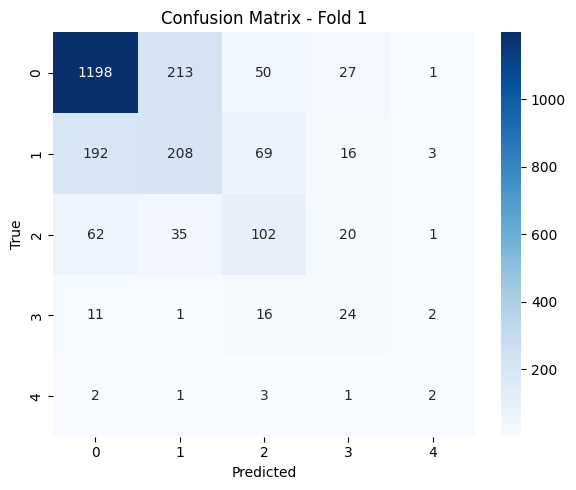

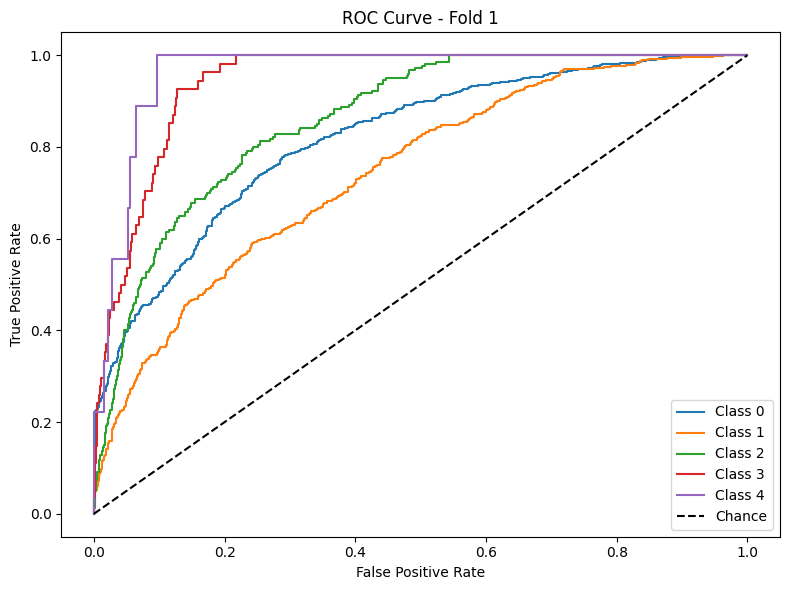


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80      1489
           1       0.45      0.43      0.44       489
           2       0.38      0.43      0.41       219
           3       0.20      0.31      0.25        55
           4       0.33      0.12      0.18         8

    accuracy                           0.66      2260
   macro avg       0.44      0.42      0.42      2260
weighted avg       0.67      0.66      0.67      2260



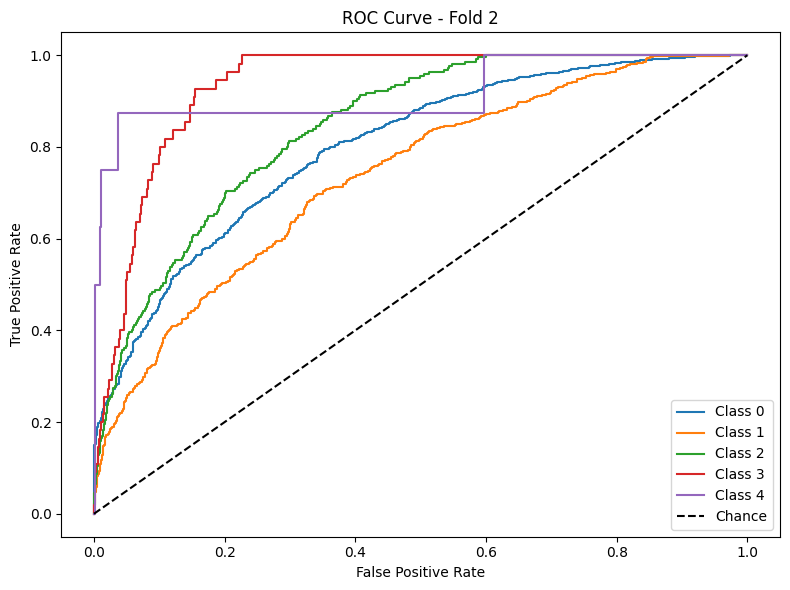


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82      1489
           1       0.45      0.40      0.43       489
           2       0.42      0.44      0.43       219
           3       0.24      0.35      0.29        54
           4       0.14      0.12      0.13         8

    accuracy                           0.68      2259
   macro avg       0.41      0.43      0.42      2259
weighted avg       0.68      0.68      0.68      2259



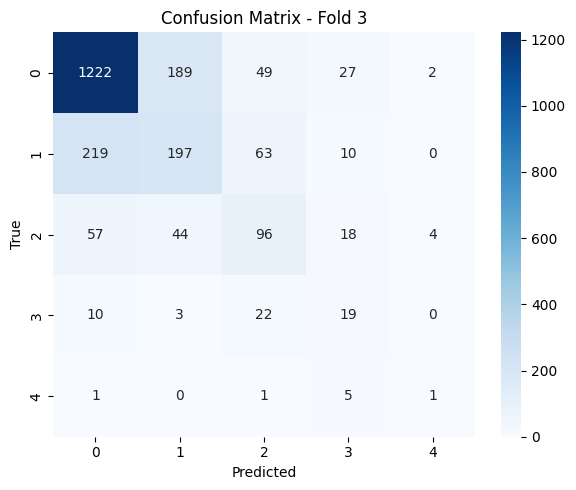

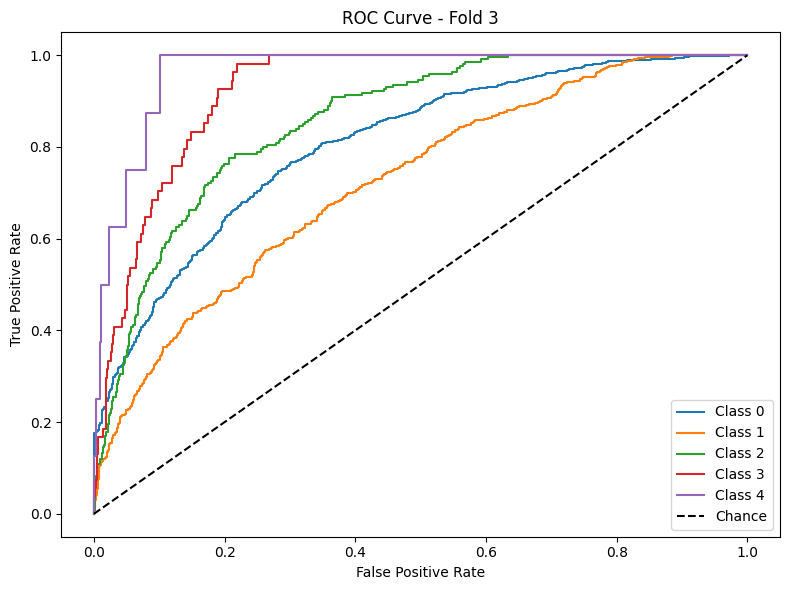


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81      1489
           1       0.47      0.44      0.45       489
           2       0.39      0.41      0.40       219
           3       0.29      0.37      0.33        54
           4       0.44      0.50      0.47         8

    accuracy                           0.68      2259
   macro avg       0.48      0.50      0.49      2259
weighted avg       0.68      0.68      0.68      2259



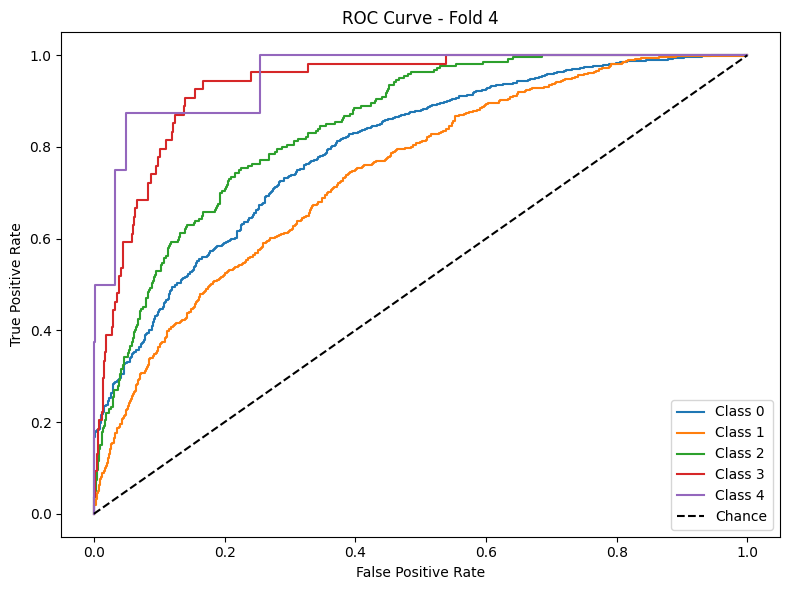


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1490
           1       0.47      0.45      0.46       488
           2       0.42      0.52      0.46       219
           3       0.26      0.24      0.25        54
           4       0.12      0.12      0.12         8

    accuracy                           0.69      2259
   macro avg       0.42      0.43      0.42      2259
weighted avg       0.69      0.69      0.69      2259



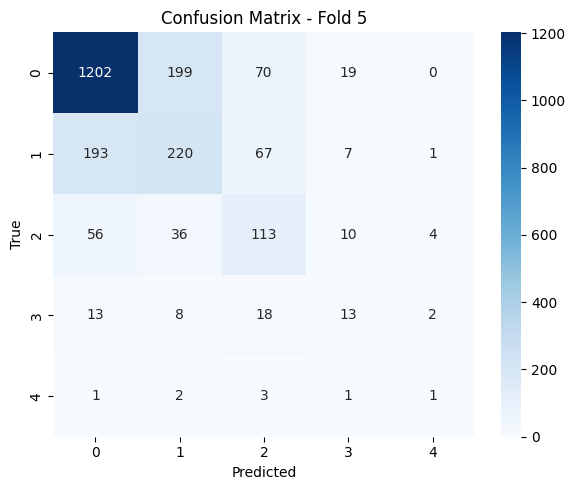

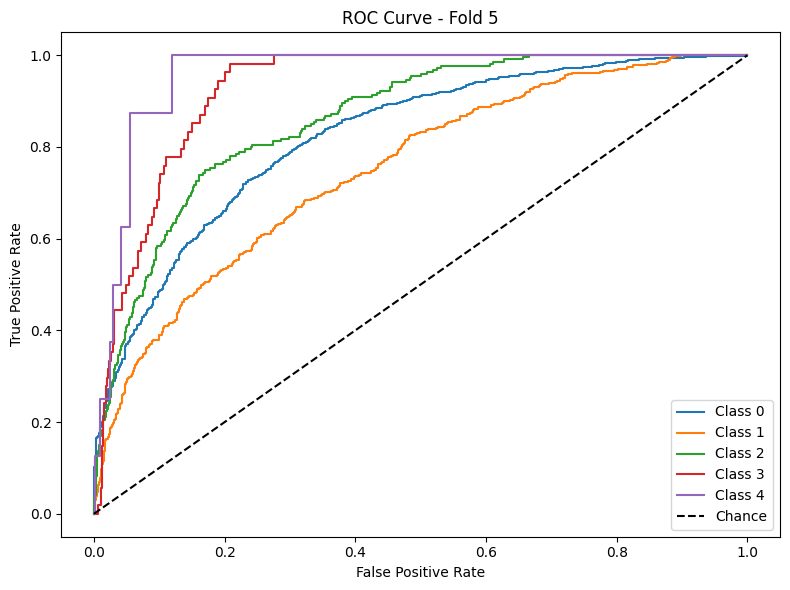


Average Accuracy: 0.6775
Average F1 Macro: 0.4395
Average AUC: 0.8572

Feature Importances:
video                                  0.186886
assignment                             0.108427
encoded_field_sum                      0.071409
chapter_count                          0.034279
video_count                            0.030043
exercise_count                         0.026481
exercise_perc_real_completed_mean_1    0.022482
exercise_context_sum_1                 0.022316
duration_days                          0.018416
exercise_correct_sum_1                 0.018040
exam                                   0.017876
user_month                             0.015310
combined_emb_9                         0.014703
num_prerequisites                      0.012656
exercise_correct_mean_2                0.012563
exercise_correct_mean_1                0.012317
exercise_correct_sum_2                 0.012080
combined_emb_7                         0.011914
combined_emb_5                         0.01

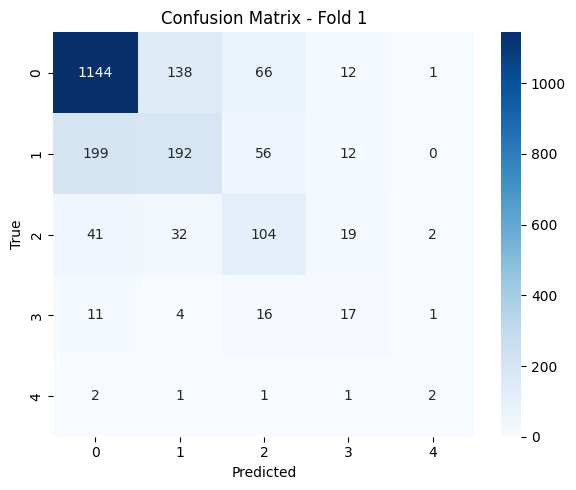

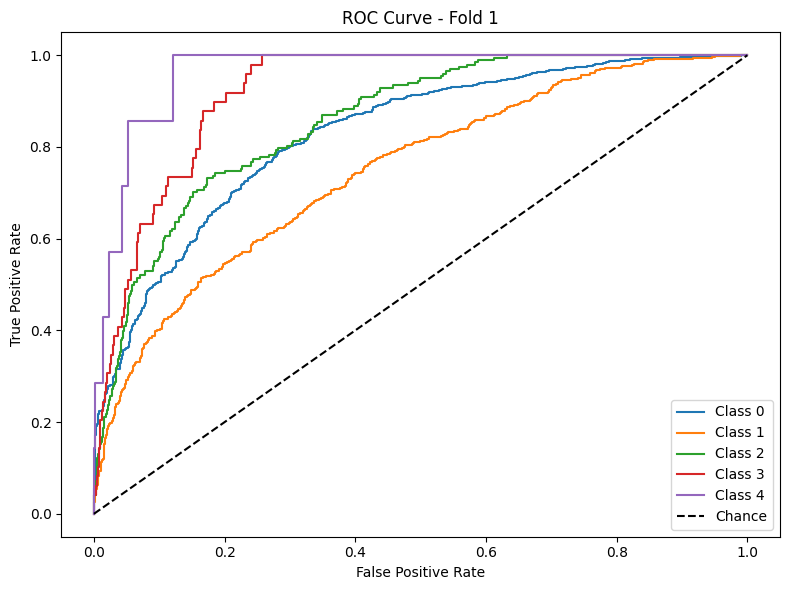


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1360
           1       0.44      0.42      0.43       459
           2       0.42      0.47      0.45       198
           3       0.29      0.34      0.31        50
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.39      0.41      0.40      2074
weighted avg       0.68      0.68      0.68      2074



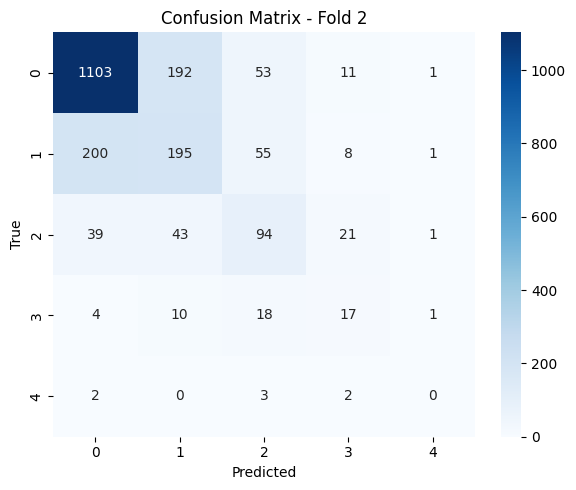

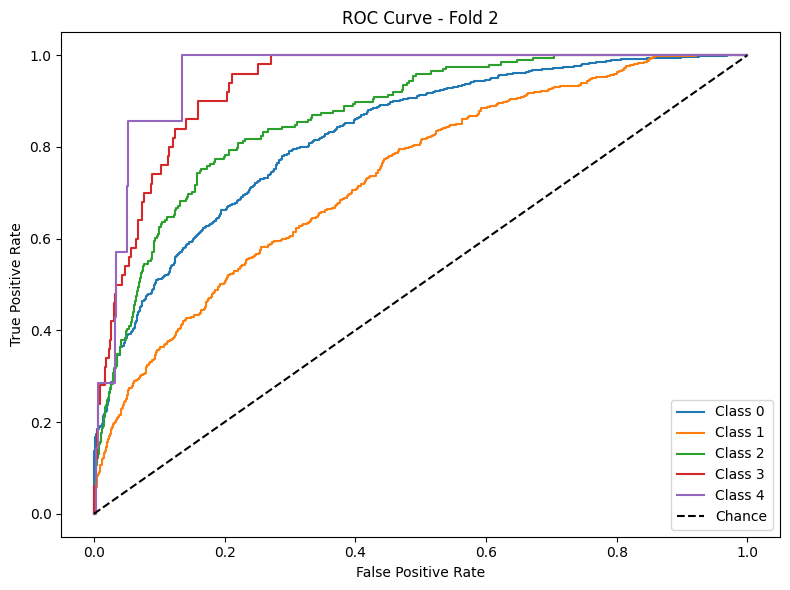


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      1360
           1       0.48      0.43      0.45       459
           2       0.39      0.49      0.43       198
           3       0.29      0.38      0.33        50
           4       0.12      0.14      0.13         7

    accuracy                           0.69      2074
   macro avg       0.42      0.45      0.43      2074
weighted avg       0.69      0.69      0.69      2074



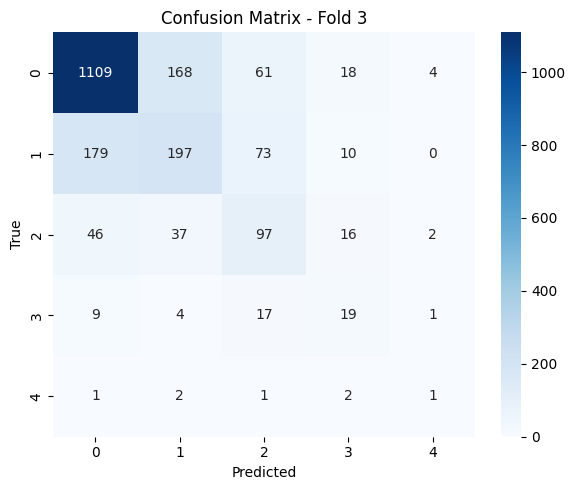

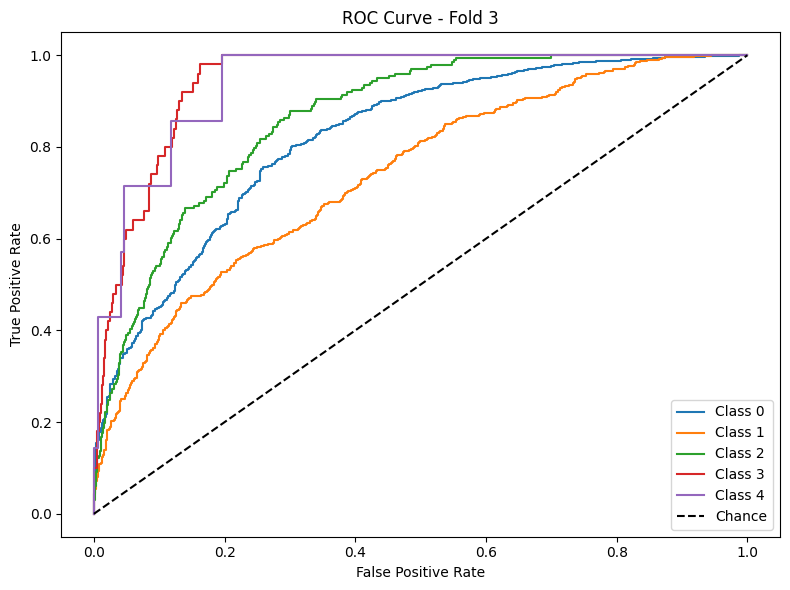


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1360
           1       0.46      0.44      0.45       459
           2       0.42      0.44      0.43       198
           3       0.29      0.32      0.30        50
           4       0.40      0.29      0.33         7

    accuracy                           0.68      2074
   macro avg       0.47      0.46      0.46      2074
weighted avg       0.68      0.68      0.68      2074



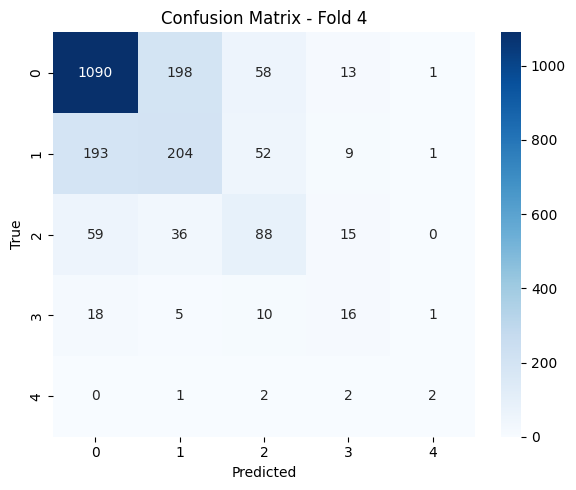

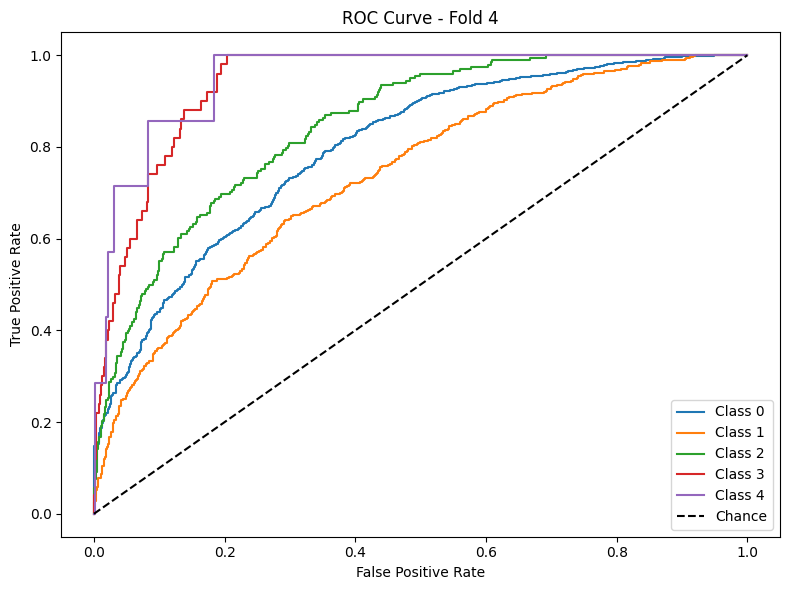


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      1360
           1       0.47      0.46      0.46       460
           2       0.41      0.47      0.44       197
           3       0.25      0.31      0.28        49
           4       0.14      0.14      0.14         7

    accuracy                           0.68      2073
   macro avg       0.42      0.43      0.43      2073
weighted avg       0.68      0.68      0.68      2073



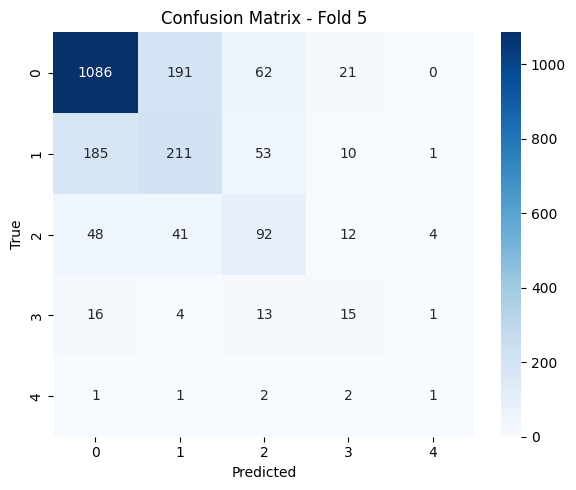

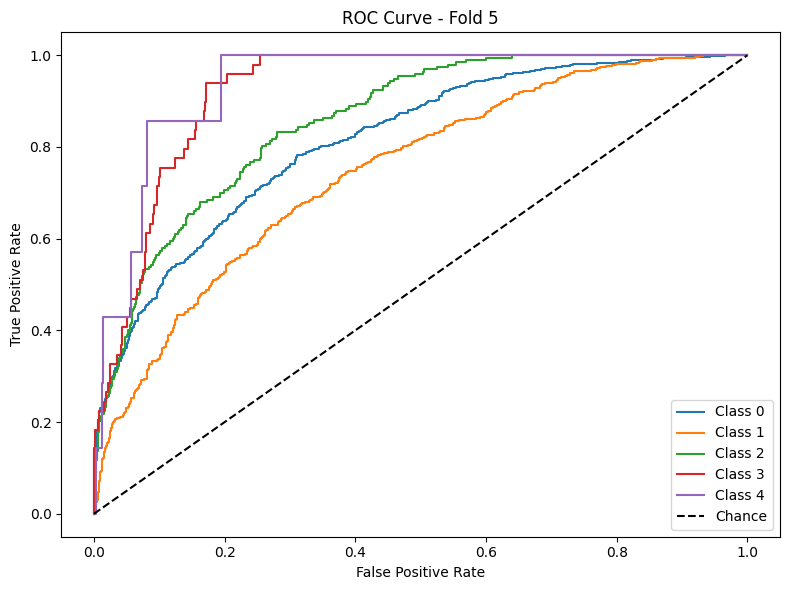


Average Accuracy: 0.6843
Average F1 Macro: 0.4405
Average AUC: 0.8596

Feature Importances:
video                                  0.176705
assignment                             0.097241
exam                                   0.051299
exercise_langugage_binary_mean_1       0.036476
exercise_num_problem_sum_1             0.035873
certificate                            0.029798
num_prerequisites                      0.024762
combined_emb_3                         0.023621
video_count                            0.022921
encoded_field_sum                      0.022417
chapter_count                          0.021376
duration_days                          0.019622
user_month                             0.017050
exercise_count                         0.016793
exercise_context_sum_1                 0.014927
exercise_id_count_2                    0.013186
school                                 0.012719
total_positive1                        0.010041
total_neutral1                         0.00

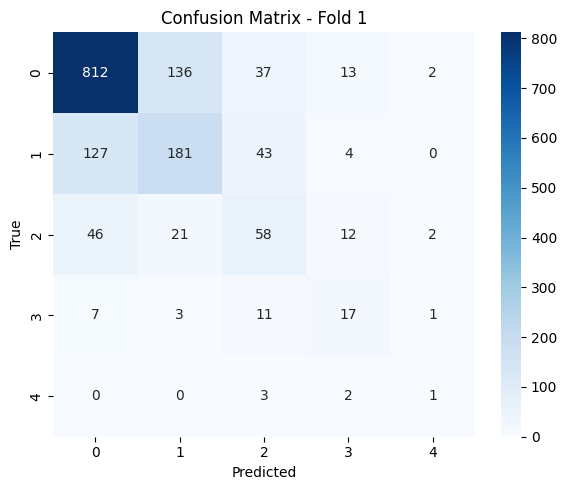

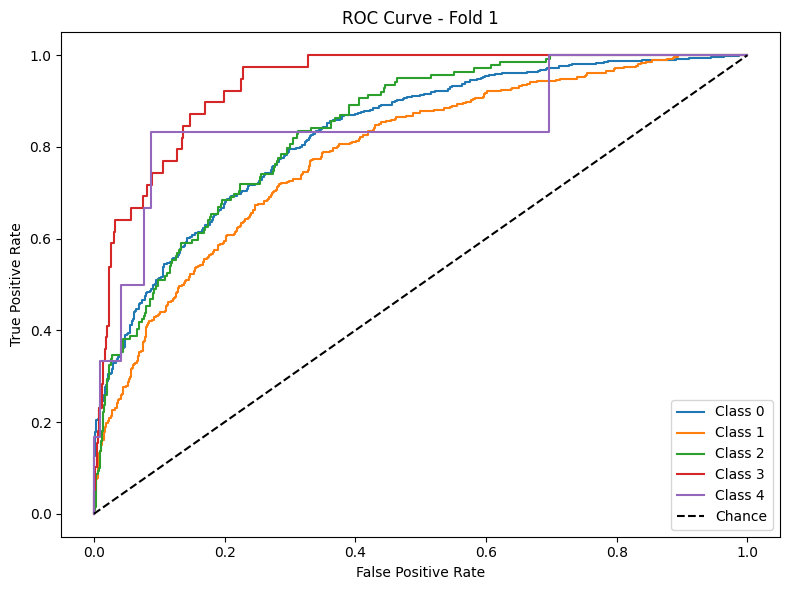


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.55      0.51      0.53       355
           2       0.51      0.53      0.52       139
           3       0.35      0.42      0.38        40
           4       0.11      0.20      0.14         5

    accuracy                           0.72      1539
   macro avg       0.47      0.50      0.48      1539
weighted avg       0.72      0.72      0.72      1539



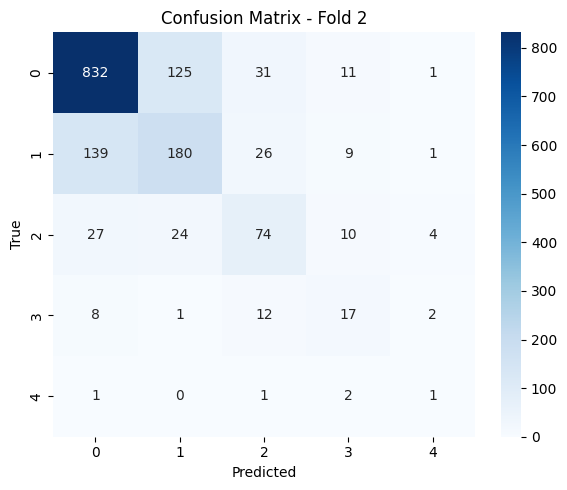

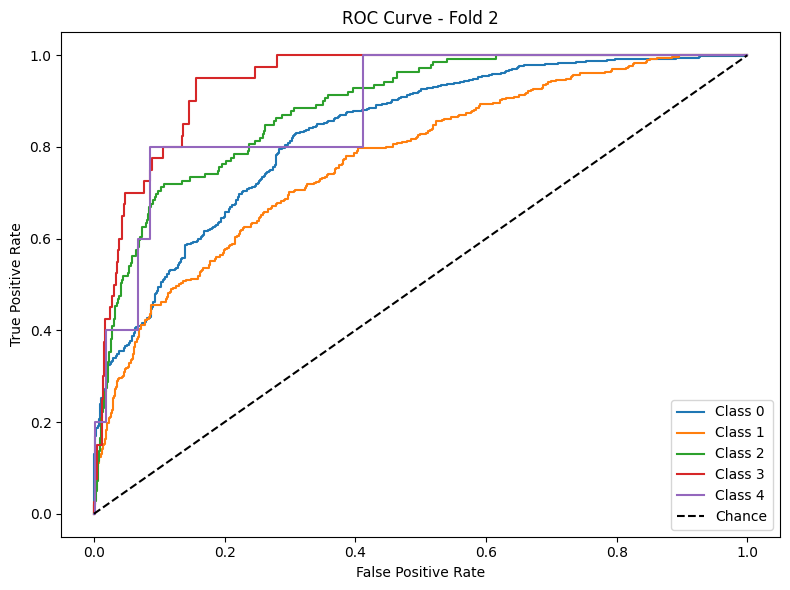


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       999
           1       0.53      0.52      0.52       355
           2       0.51      0.47      0.49       139
           3       0.41      0.50      0.45        40
           4       0.25      0.17      0.20         6

    accuracy                           0.71      1539
   macro avg       0.50      0.50      0.50      1539
weighted avg       0.71      0.71      0.71      1539



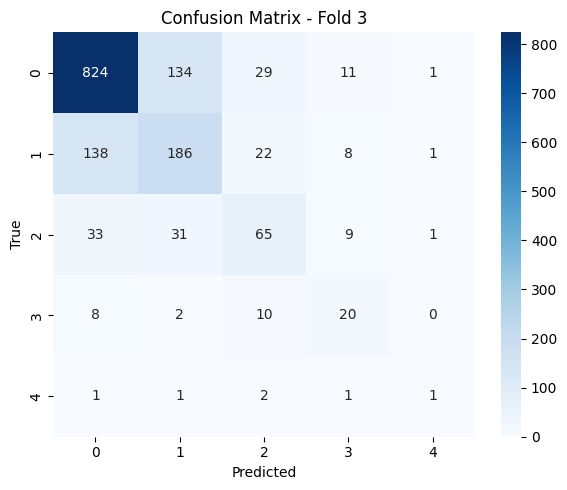

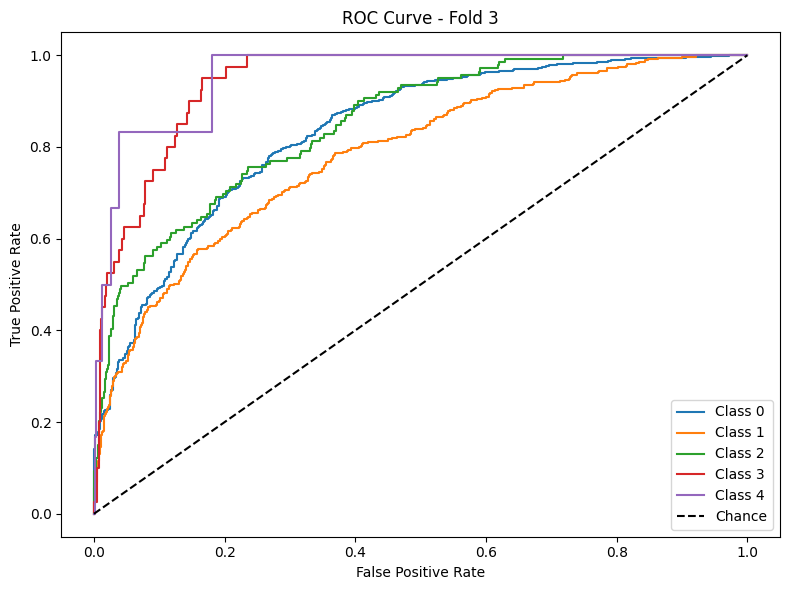


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       999
           1       0.51      0.42      0.46       356
           2       0.46      0.55      0.50       138
           3       0.32      0.31      0.31        39
           4       0.25      0.17      0.20         6

    accuracy                           0.70      1538
   macro avg       0.47      0.46      0.46      1538
weighted avg       0.69      0.70      0.70      1538



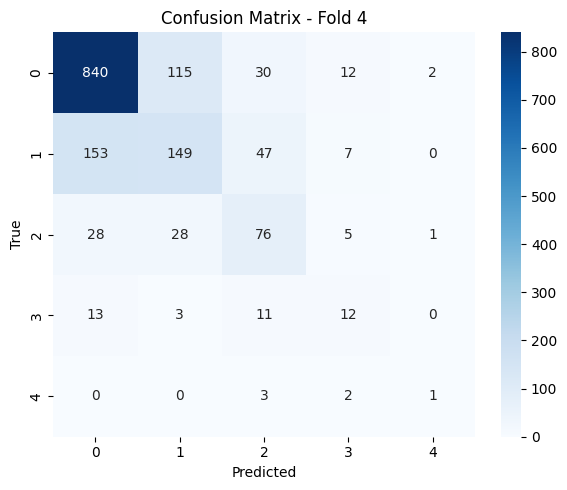

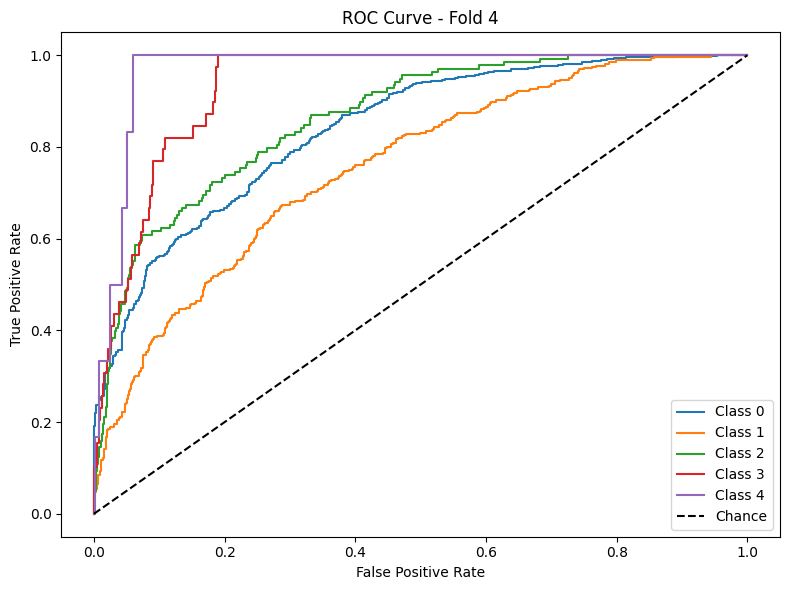


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       999
           1       0.51      0.48      0.49       356
           2       0.42      0.44      0.43       138
           3       0.40      0.54      0.46        39
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1538
   macro avg       0.43      0.46      0.44      1538
weighted avg       0.70      0.70      0.70      1538



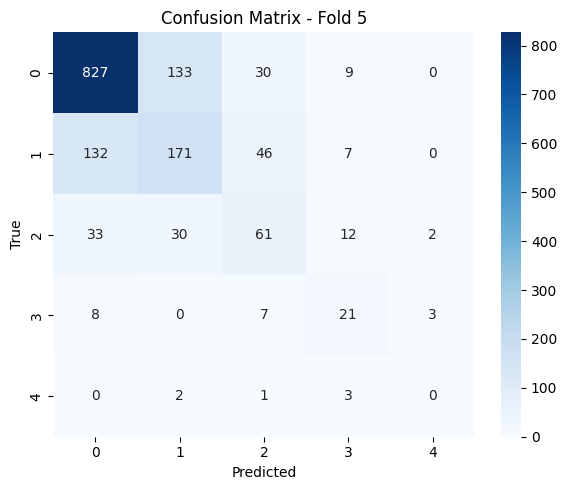

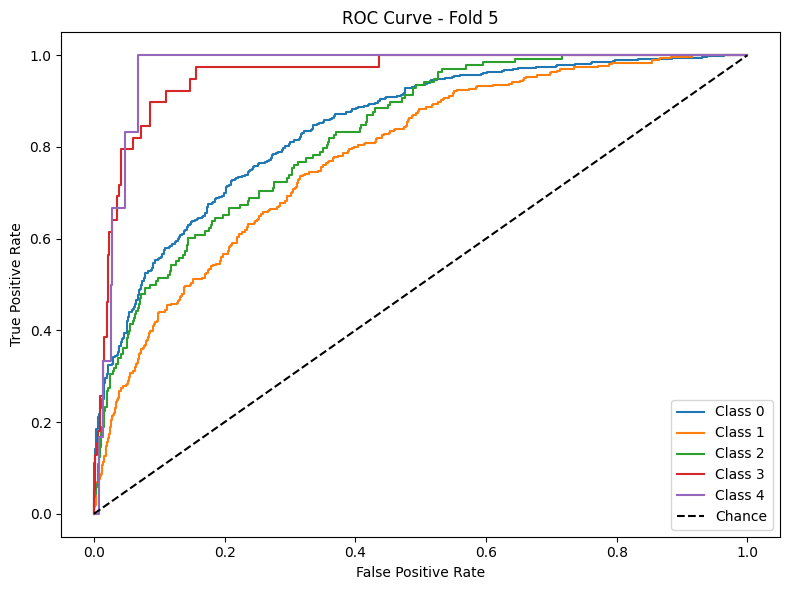


Average Accuracy: 0.7054
Average F1 Macro: 0.4674
Average AUC: 0.8663

Feature Importances:
video                                  0.126052
assignment                             0.110606
chapter_count                          0.058818
exercise_num_problem_sum_1             0.038393
exam                                   0.036084
encoded_field_sum                      0.025325
certificate                            0.022889
exercise_context_sum_1                 0.018141
exercise_count                         0.017621
combined_emb_14                        0.017552
exercise_correct_sum_1                 0.016674
exercise_correct_mean_1                0.014713
total_negative4                        0.012400
exercise_perc_real_score_mean_1        0.011820
entropy_time_comment_phase4            0.011665
exercise_correct_sum_2                 0.011613
exercise_correct_mean_2                0.011088
num_prerequisites                      0.010773
exercise_num_problem_sum_3             0.01

In [9]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n==============================================")
    print(f"\n========== Training Phase {i} ================")
    print(f"\n==============================================")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       568
           1       0.40      0.30      0.34        63
           2       0.27      0.16      0.20        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.31      0.28      0.29       698
weighted avg       0.77      0.82      0.79       698



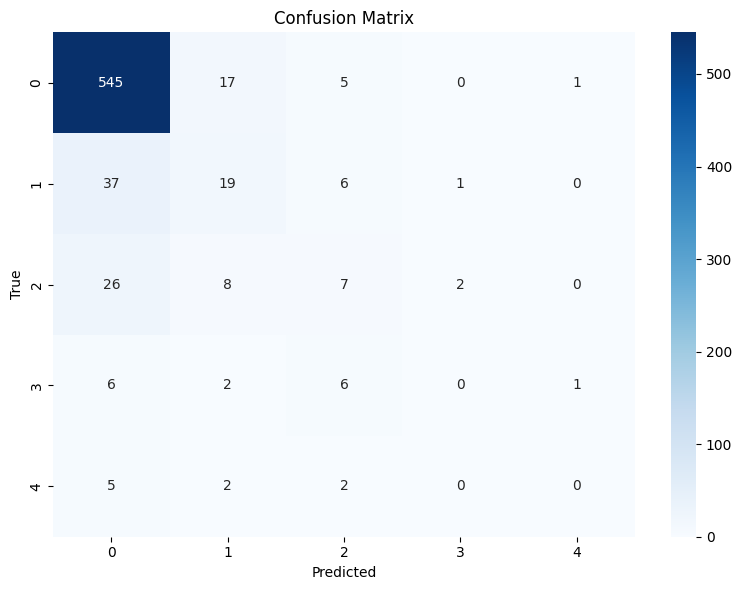


Test AUC (macro-average, OVR): 0.8531


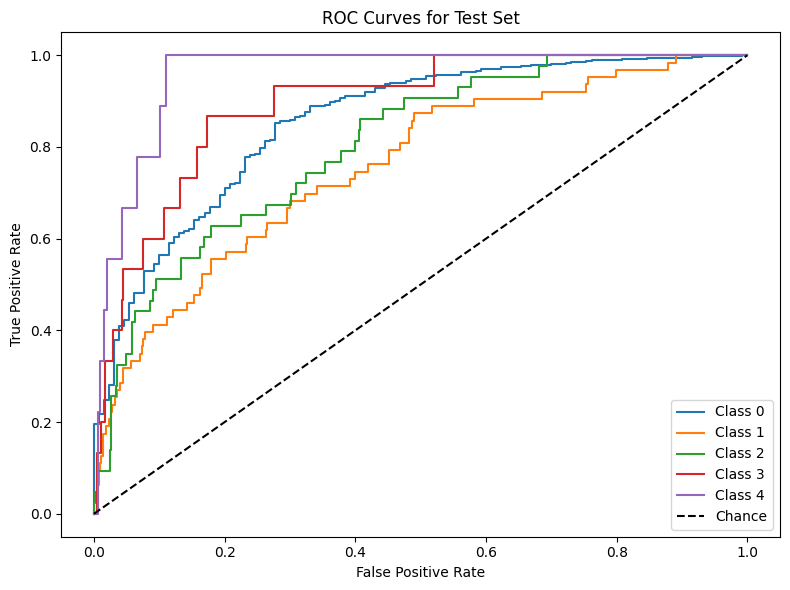


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       544
           1       0.38      0.24      0.29        59
           2       0.23      0.17      0.19        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.30      0.27      0.28       668
weighted avg       0.76      0.81      0.78       668



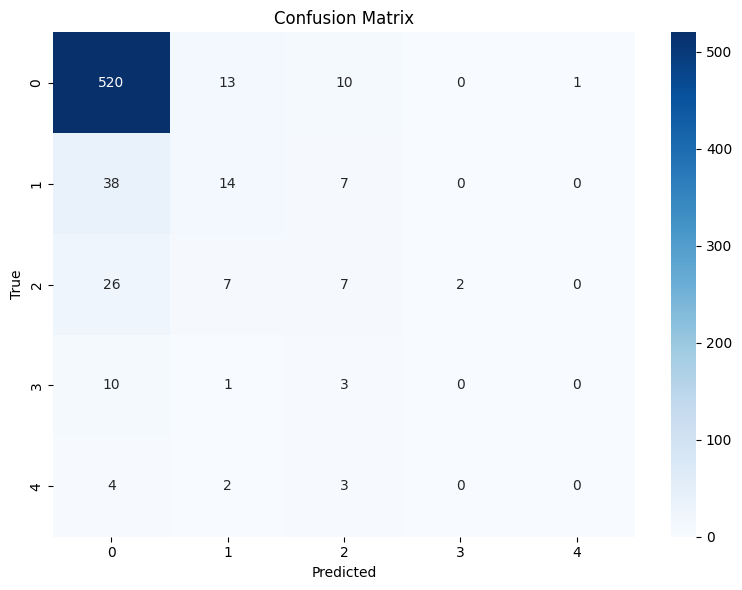


Test AUC (macro-average, OVR): 0.8409


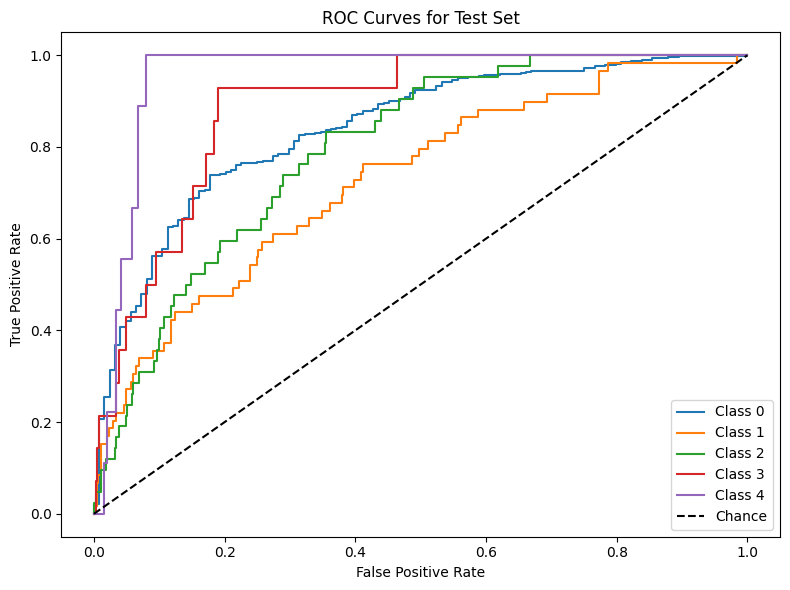


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       455
           1       0.42      0.15      0.23        52
           2       0.14      0.07      0.09        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.28      0.24      0.25       554
weighted avg       0.75      0.82      0.77       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


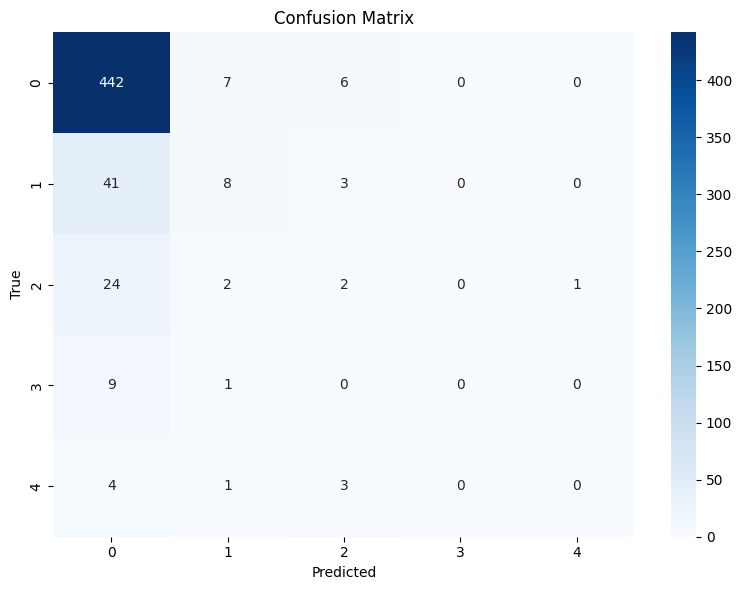


Test AUC (macro-average, OVR): 0.8172


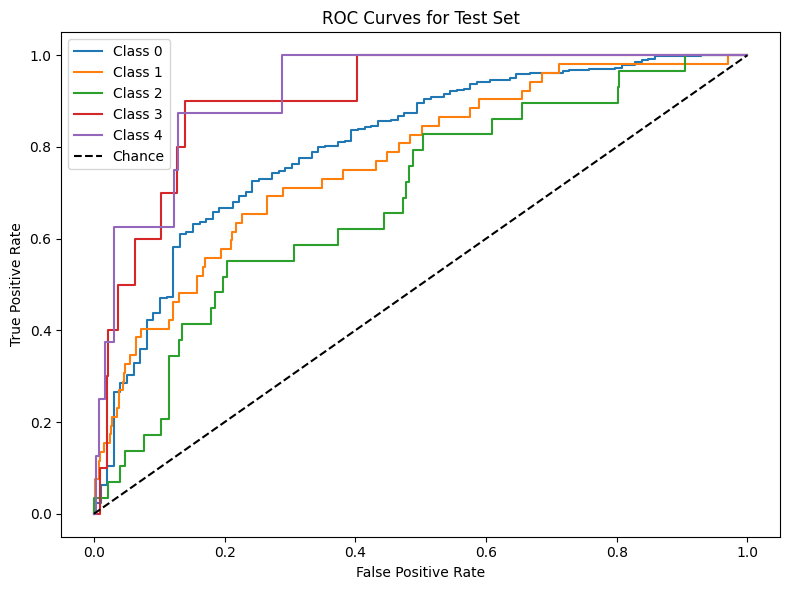


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       395
           1       0.25      0.12      0.17        40
           2       0.14      0.08      0.11        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.25      0.23      0.24       477
weighted avg       0.74      0.81      0.77       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


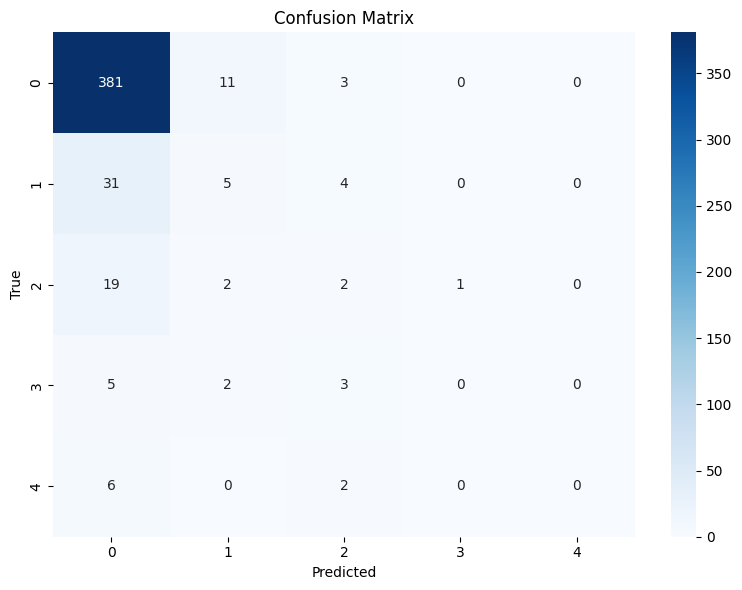


Test AUC (macro-average, OVR): 0.7560


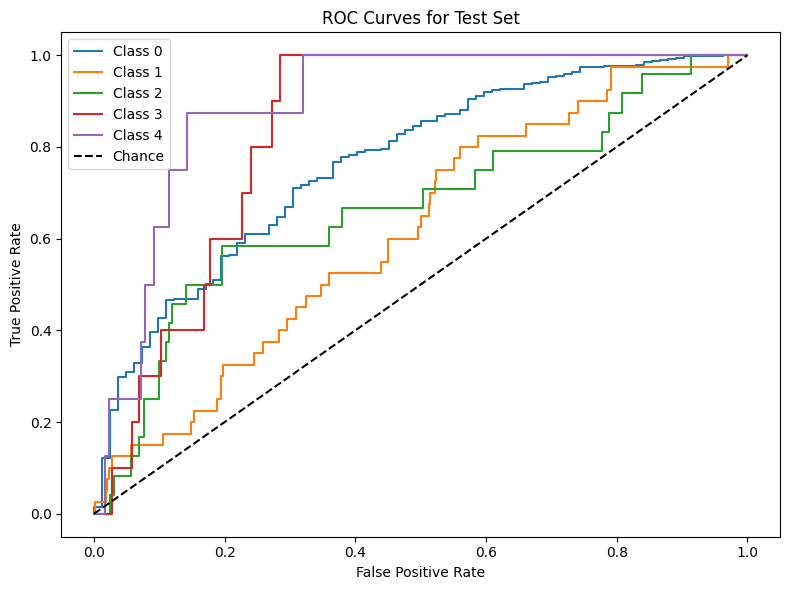

In [10]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)